In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np 
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
inputs_df = pd.read_csv('data/inputs_init.csv')
inputs_df.columns = ['sample','objective', 'time','dilution_factor','C00058','C00004','C00037','C00149','C00022','C00065','C00036','C00002','C00020','C00010','C00033','C00158HCT','C00011','C00024','p_hEC11719', 'p_hEC11137','p_hEC6411','p_hEC43117']
inputs_df['time'] = inputs_df['time'].apply(lambda x: (x*60+15)*60)

data_df = pd.read_csv('data/data.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_df.columns = ['sample','C00149','C00022','C00065','C00037','C00004','C00010','C00024','C00042','C00122','C00158','C00002','C00048','C00041','C00049','C00047','C00183','C00109','C02630']
data_weights_df = pd.read_csv('data/data_weights_mod.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_stds_df = pd.read_csv('data/data_stds.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_stds_df.columns = data_df.columns

In [3]:
def split_df(df, test_on):
    test_vars_df = df[df['sample'].apply(lambda x: any(name in x for name in test_on))]
    train_vars_df = df[~df['sample'].apply(lambda x: any(name in x for name in test_on))]
    return [test_vars_df, train_vars_df]

test_on = ['gly','mal','ser','pyr','empty','tdcb','pyc','mdh']
test_on = inputs_df['sample'].apply(lambda x: '_'.join(x.split('_')[:-1]))
test_vars_df, train_vars_df, test_data_df, train_data_df, test_weights_df, train_weights_df,test_stds_df, train_stds_df =  sum([split_df(df, test_on) for df in [inputs_df, data_df, data_weights_df, data_stds_df]],[])

In [4]:
# test_weights_df = test_weights_df.set_index('sample')
# test_weights_df[test_weights_df<1] = 0.0001
# test_weights_df = test_weights_df.reset_index()

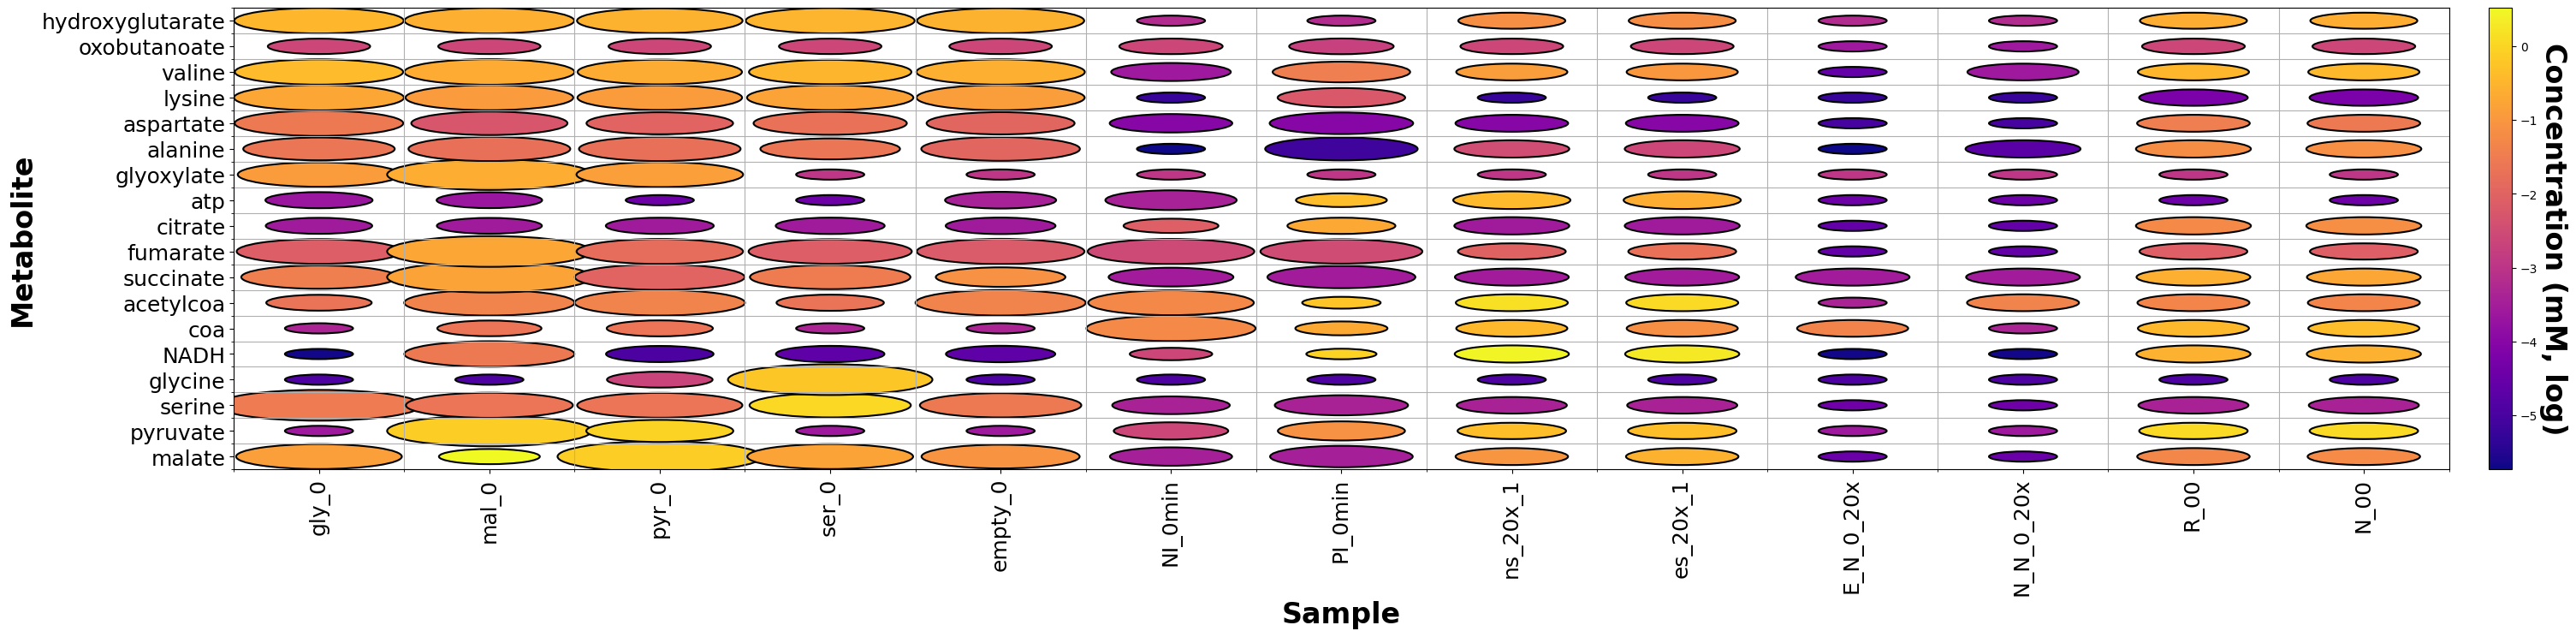

In [4]:
from matplotlib.collections import PatchCollection

def circlemap(data_df, data_weights_df, figsize=(40, 7), ignore = None, log = True, cmap = 'plasma'):
       if ignore:
              data_df = data_df[:-ignore]
              data_weights_df = data_weights_df[:-ignore]
       N, M = data_df.T.shape
       ylabels = data_weights_df.drop(columns=['sample'],inplace=False).columns
       xlabels = data_df['sample']

       x, y = np.meshgrid(np.arange(M), np.arange(N-1))
       s = data_weights_df.drop(columns=['sample'], inplace=False).T.values
       if log:
              c = np.log10(data_df.drop(columns=['sample'], inplace=False).T.values)
       else:
              c = data_df.drop(columns=['sample'], inplace=False).T.values
       fig, ax = plt.subplots(figsize=figsize)

       s[s>1]=1.2
       R = s/2
       circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
       col = PatchCollection(circles, array=c.flatten(), cmap=cmap, edgecolors='black', linewidth=1.5)
       ax.add_collection(col)

       ax.set(xticks=np.arange(M), yticks=np.arange(N-1),
              xticklabels=xlabels, yticklabels=ylabels)
       ax.set_xticks(np.arange(M+1)-0.5, minor=True)
       ax.set_yticks(np.arange(N)-0.5, minor=True)
       ax.grid(which='minor')

       plt.xticks(rotation=90)
       plt.tick_params(axis='both', which='major', labelsize=18)

       cbar = fig.colorbar(col, pad = 0.015)
       if log:
              cbar.set_label('Concentration (mM, log)', rotation=270, fontsize=24, labelpad=25, fontdict={'weight': 'bold'})
       else:
              cbar.set_label('Concentration (mM)', rotation=270, fontsize=24, labelpad=25, fontdict={'weight': 'bold'})


       plt.xlabel('Sample', fontsize=24, fontdict={'weight': 'bold'})
       plt.ylabel('Metabolite', fontsize=24, fontdict={'weight': 'bold'})

       plt.show()
       
circlemap(data_df, data_weights_df)

In [5]:
test_index_map = pd.merge(test_vars_df, test_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index','objective']].sort_values(['index','time'])
train_index_map = pd.merge(train_vars_df, train_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index','objective']].sort_values(['index','time'])

In [6]:
train_vars = [train_vars_df.drop(columns=['sample','time','objective'], inplace=False).drop_duplicates().T.to_dict()]
test_vars = [test_vars_df.drop(columns=['sample','time','objective'], inplace=False).drop_duplicates().T.to_dict()]

train_metadata = [{}]
train_metadata[0]['sample_labels'] = list(train_vars[0].keys())
train_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
train_metadata[0]['timepoints'] = train_index_map.groupby('index')['time'].apply(list).to_dict()
train_metadata[0]['objective'] = train_index_map.drop_duplicates('index')['objective'].values

test_metadata = [{}]
test_metadata[0]['sample_labels'] = list(test_vars[0].keys())
test_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
test_metadata[0]['timepoints'] = test_index_map.groupby('index')['time'].apply(list).to_dict()
test_metadata[0]['objective'] = test_index_map.drop_duplicates('index')['objective'].values

train_data=[{}]
train_weights=[{}]
for index, samples in train_index_map.groupby('index')['sample'].apply(list).items():
    train_data[0][index]=train_data_df.loc[train_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    train_weights[0][index]=train_weights_df.loc[train_weights_df['sample'].isin(samples)].drop(columns=['sample']).values

test_data=[{}]
test_weights=[{}]
for index, samples in test_index_map.groupby('index')['sample'].apply(list).items():
    test_data[0][index]=test_data_df.loc[test_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    test_weights[0][index]=test_weights_df.loc[test_weights_df['sample'].isin(samples)].drop(columns=['sample']).values


In [8]:
# load SBML model
modelfile = os.getcwd()+'/models/M3a.sbml'
r = te.loadSBMLModel(modelfile)

In [9]:
# get all the parameters that can vary during the fitting
kcat_labels = [p for p in r.getGlobalParameterIds() if 'Kcat_V' in p]
keq_labels = [p for p in [p for p in r.getGlobalParameterIds() if 'Keq' in p] if r[p]==1]
keq2_labels = [p for p in [p for p in r.getGlobalParameterIds() if 'Keq' in p] if r[p]!=1]
km_labels = [p for p in r.getGlobalParameterIds() if 'Km' in p]
ki_labels = [p for p in r.getGlobalParameterIds() if 'Ki' in p]
Gnc_labels = [p for p in r.getGlobalParameterIds() if 'Gnc' in p]
Gc_labels = [p for p in r.getGlobalParameterIds() if 'Gc' in p ]
kdeg_labels= [p for p in r.getGlobalParameterIds() if 'kdeg' in p]

sbml = r.getSBML()
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [v for v in  [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s):sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s)+5]).split(' ')[0] for s in metabolites] if 'v' in v]
heterologous_expression = [p for p in r.getGlobalParameterIds() if 'rel' in p][1:]

# parameter_labels = kcat_labels + keq_labels + km_labels + ki_labels + Gnc_labels + Gc_labels + kdeg_labels + metabolites_labels + heterologous_expression
parameter_labels = kcat_labels + keq_labels + keq2_labels + km_labels + kdeg_labels + metabolites_labels + heterologous_expression
# parameter_labels = metabolites_labels + heterologous_expression
parameter_labels.append('rel0') # what are good bounds for this?
# parameter_labels.append('t0') 

# make upper and lower bounds
upper = np.log10(np.array(
                  [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)*100000 for i in kcat_labels] + 
                 [100000 for i in keq_labels] +
                 [r[i]*3 for i in keq2_labels] +
                 [r[i]*100000 for i in km_labels] + 
                #  [r[i]*10000 for i in ki_labels] +
                #  [1 for _ in Gnc_labels] +
                #  [1 for _ in Gc_labels] +
                #  [r[i]*1000 for i in kdeg_labels] +
                 [100000 for _ in metabolites_labels] + 
                 [100000 for _ in heterologous_expression] +
                 [100000]))# +
                #  [150*60]))

lower = np.log10(np.array(
                [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)/100000 for i in kcat_labels] + 
                 [1/100000 for i in keq_labels] +
                 [r[i]/3 for i in keq2_labels] +
                 [r[i]/100000 for i in km_labels] + 
                #  [r[i]/10000 for i in ki_labels] +
                #  [1/100 for _ in Gnc_labels] +
                #  [1/100 for _ in Gc_labels] +
                #  [r[i]/1000 for i in kdeg_labels] +
                 [1/100000 for _ in metabolites_labels] + 
                 [1/100000 for _ in heterologous_expression] +
                 [1/100000]))# +
                #  [1*60]))

p_initial = np.log10(np.array(
                    [((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5) for i in kcat_labels] + 
                     [r[i] for i in keq_labels] +
                     [r[i] for i in keq2_labels] +
                     [r[i] for i in km_labels] + 
                    #  [r[i] for i in ki_labels] +
                    #  [0.9 for _ in Gnc_labels] +
                    #  [0.9 for _ in Gc_labels] +
                    #  [r[i] for i in kdeg_labels] +
                     [1 for _ in metabolites_labels] + 
                     [1 for _ in heterologous_expression] +
                     [1]))# +
                    #  [15*60]))

widths = np.log10(np.array(
                  [10 for _ in kcat_labels] +
                  [10 for _ in keq_labels] + 
                  [2 for i in keq2_labels] +
                  [10 for _ in km_labels] + 
                #   [10000 for _ in ki_labels] +
                #   [1 for _ in Gnc_labels] +
                #   [1 for _ in Gc_labels] +
                  # [10 for _ in kdeg_labels] +
                  [1000 for _ in metabolites_labels] + 
                  [1000 for _ in heterologous_expression] +
                  [1000]))# +
                  # [10]))

In [10]:
with open('results/241206_M3a/parameters_init_wk_all.dat', 'wb') as file:
    pickle.dump([p_initial,upper,lower,widths],file)

In [11]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
train_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = train_data, 
    data_weights=train_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=train_metadata,
    variables=train_vars,
    extra_residuals = [None],
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=0,
    dlambda = 0,
    llambda=0,
    lelambda=0,
    ldlambda = 0,
    lllambda=0,
    elambda2=0,
    dlambda2 = 0,
    llambda2=0,
    lelambda2=0,
    ldlambda2 = 1,
    lllambda2=0,
    rmse='mean',
    objf='multi_error')

test_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = test_data, 
    data_weights=test_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=test_metadata,
    variables=test_vars,
    extra_residuals = [None],#[[[5,23,'C00022'],[5,23,'C00122'],[5,23,'C00042'],[5,23,'C00048']]],
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=0,
    dlambda = 0,
    llambda=0,
    lelambda=0,
    ldlambda = 0,
    lllambda=0,
    elambda2=0,
    dlambda2 = 0,
    llambda2=0,
    lelambda2=1,
    ldlambda2 = 0,
    lllambda2=1,
    rmse='sum',
    objf='single_error', 
    normalize_fitness=False,
    fitness_std=False)

test_myprob.nominal_fitness = [1,1,1,1,1,1]



train_prob = pg.problem(test_myprob) # SWAPED THEM HERE FOR TESTING
test_prob = pg.problem(train_myprob)

In [40]:
with open('results/241206_M3a/myprobs_init_wk_all.obj', 'wb') as file:
    pickle.dump([train_myprob,test_myprob], file)

In [12]:
test_myprob._setup_rr()
test_myprob.fitness(p_initial)

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep 

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:630: RuntimeWarning:

Mean of empty slice.

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide

/mmfs1/home/dalba/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:96: UserWarning:


/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:459: RuntimeWarning:

Mean of empty slice



[264.0018019919575]

In [13]:
import ipyparallel as ipp

client = ipp.Client(profile='cheme-ecfers',cluster_id = 'test')
client[:].apply_sync(os.chdir,'/mmfs1/gscratch/cheme/dalba/repos/ECFERS');

def set_affinity_on_worker():
    """When a new worker process is created, the affinity is set to all CPUs"""
    import os
    os.system("taskset -p 0xffffffffff %d" % os.getpid())

client[:].apply_sync(set_affinity_on_worker);

In [14]:
from src.fitting.pygmo_bfes import pickleless_bfe2
udbfe = pickleless_bfe2(client_kwargs={'profile':'cheme-ecfers', 'cluster_id':'test'}, view_kwargs = {'targets':range(len(client[:]))}, temp_dv_path = os.getcwd()+'/models/binaries2', prob = {'train':train_prob, 'test':test_prob})
udbfe.init_view()
mybfe = pg.bfe(udbfe)

In [84]:
udbfe._views[0].push({'prob_train': train_prob,'prob_test': test_prob}, block = True)
udbfe._views[0].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train'))
udbfe._views[0].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_test'))
udbfe._views[0].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._set_nominal_fitness([1,1,1,1,1,1]), ipp.Reference('prob_test'))
mybfe = pg.bfe(udbfe)

In [15]:
# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
algos = []
pops = []
replicates = 1
for i in range(replicates):
    a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.1, variant=5, neighb_type=2, neighb_param=4, memory=True)
    # a = pg.cmaes(gen=10, sigma0=0.1, memory = True)
    # a = pg.gaco(gen=10)
    # a = pg.moead_gen(gen=10,weight_generation='low discrepancy', decomposition='tchebycheff', neighbours=20, CR=1, F=0.3, eta_m=20, realb=0.9, limit=2, preserve_diversity=True)
    a.set_bfe(mybfe)
    algo = pg.algorithm(a)
    algo.set_verbosity(1)
    algos.append(algo)
    pops.append(pg.population(train_prob, size = 0))

In [ ]:
with open('results/240829_M3/240828_train_myprob_3AB.obj', 'rb') as file:
    train_myprob = pickle.load(file)

with open('results/240829_M3/checkpoint_ABR.dat', 'rb') as file:
    pops = pickle.load(file)

with open('results/240829_M3/bounds_ABR2.dat', 'rb') as file:
    all_lower,all_upper = pickle.load(file)

train_myprob.set_bounds(all_upper[-1],all_lower[-1])
train_prob = pg.problem(train_myprob)
test_myprob.set_bounds(all_upper[-1],all_lower[-1])
test_prob = pg.problem(test_myprob)

In [16]:
total_nodes = len(client[:])*4
# xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(p-w,p+w, total_nodes)) for p,w in zip(p_initial,widths)])).T
# fs = udbfe(train_prob,xs.reshape(-1))
for p in pops:
    xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(p-w,p+w, total_nodes)) for p,w in zip(p_initial,widths)])).T
    # xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(l,u, total_nodes)) for l,u in zip(lower,upper)])).T
    fs = udbfe(train_prob,xs.reshape(-1))
    list(map(p.push_back, xs, fs.reshape(total_nodes,-1)))

with open('results/241206_M3a/pops0_init_wk_wkeq_2.dat', 'wb') as file:
    pickle.dump(pops, file)

In [ ]:
bestN = lambda N,pops: np.concatenate([np.apply_along_axis(lambda x: (x),1, p.get_x()[np.argsort(p.get_f()[:,0])[:N],:]) for p in pops])
sampleM_fromN = lambda M,N,pops: np.random.multivariate_normal(np.mean(bestN(N,pops),0),np.cov(bestN(N,pops),rowvar=False),size=M)

with open('results/241206_M3a/pops_init_wk.dat', 'rb') as file:
    pops_init= pickle.load(file)

total_nodes = len(client[:])*4
for p in pops:
    xs = sampleM_fromN(total_nodes,112,pops_init)[:,:-1]
    fs = udbfe(train_prob,xs.reshape(-1))
    list(map(p.push_back, xs, fs.reshape(total_nodes,-1)))

with open('results/241206_M3a/pops0_init_wk_all_3.dat', 'wb') as file:
    pickle.dump(pops, file)

In [16]:
np.nanmin(fs.reshape(total_nodes,-1),0)

array([129.8575926])

In [86]:
with open('results/241206_M3a/logs_init_wk_all_2.dat', 'rb') as file:
    logs = pickle.load(file)

with open('results/241206_M3a/pops0_init_wk_all_2.dat', 'rb') as file:
    pops = pickle.load(file)
    
with open('results/241206_M3a/fs_init_wk_all_2.dat', 'rb') as file:
    all_fs = pickle.load(file)

In [ ]:
train_myprob.set_bounds(all_upper[-1],all_lower[-1])
train_prob = pg.problem(train_myprob)
test_myprob.set_bounds(all_upper[-1],all_lower[-1])
test_prob = pg.problem(test_myprob)

udbfe._view.push({'prob_train': train_prob, 'prob_test': test_prob}, block = True)
udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train'))
udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_test'))
mybfe = pg.bfe(udbfe)


In [32]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")

# logs = []
# all_fs = []
for i in range(500):
    print(now() + ' - Starting evolution ' + str(i))
    # ar_fs = [u.run_evolve(None,pop, block=False) for u,pop in zip(udis,pops)] # submot asynchroneously
    # [ar.get() for ar in ar_fs]; # wait for all to finish
    # pops = [u._load_pop() for u in udis] # load the population from the engines/storage
    pops = [a.evolve(p) for a,p in zip(algos,pops)]
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.get_f().mean(1).min() for p in pops])))

    [logs.append(a.extract(pg.pso_gen).get_log()) for a in algos]
    all_fs.append([p.get_f() for p in pops])

    with open('results/241206_M3a/pops_init_wk_wkeq_2.dat', 'wb') as file:
        pickle.dump(pops, file)
    with open('results/241206_M3a/logs_init_wk_wkeq_2.dat', 'wb') as file:
        pickle.dump(logs, file)
    with open('results/241206_M3a/fs_init_wk_wkeq_2.dat', 'wb') as file:
        pickle.dump(all_fs, file)

# # logs = [[] for _ in range(replicates)]
# # test_fit = []
# all_upper = [train_myprob.upperb]
# all_lower = [train_myprob.lowerb]
# n=0 
# for k in range(100):
#     print(now() + ' - Starting evolution ' + str(k))
#     pops = [a.evolve(p) for a,p in zip(algos,pops)]

#     print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))
    
#     # test_fit.append([[udbfe(test_prob,p.get_x().reshape(-1), mode = 'test')] for p in pops])
#     for i,a in enumerate(algos):
#         logs[i].append(np.array(a.extract(pg.pso_gen).get_log()))
            
#     with open('results/241025_M3_single/logs3.dat', 'wb') as file:
#         pickle.dump([logs,test_fit], file)

#     with open('results/241025_M3_single/pops3.dat', 'wb') as file:
#         pickle.dump(pops, file)
    
    # if (k>0) & (k%20 == 0):
    #     print(now() + ' - Changing bounds, resampling population')

    #     x_u = np.apply_along_axis(train_myprob._unscale, 1, pops[0].get_x())
    #     f_u = pops[0].get_f()

    #     increase_lower = sum(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*5//100],:]<train_myprob._scale(p_initial)/(100*(5**n)))>0 # /30>0.3 # divide by extra 5 each round
    #     increase_upper = sum(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*5//100],:]>0.95)>0 # /30>0.3
    #     n += 1
        
    #     new_upper = increase_upper*train_myprob.upperb+np.log10(5) + (~increase_upper)*train_myprob._unscale(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*75//100],:].max(0))
    #     new_lower = increase_lower*train_myprob.lowerb-np.log10(5) + (~increase_lower)*train_myprob._unscale(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*75//100],:].min(0))
    #     new_upper[['G' in p for p in parameter_labels]] = 1 # clamp G to 1
    #     new_upper,new_lower = np.max([new_upper, new_lower], axis = 0), np.min([new_upper, new_lower], axis = 0) # make sure lower < upper
        
    #     keep = []
    #     for i,x in enumerate(x_u):
    #         if (np.all([x <= new_upper]) & np.all([x >= new_lower])):
    #             keep.append(i)

    #     train_myprob.set_bounds(new_upper,new_lower)
    #     # train_prob = pg.problem(train_myprob)
    #     test_prob = pg.problem(train_myprob)

    #     test_myprob.set_bounds(new_upper,new_lower)
    #     # test_prob = pg.problem(test_myprob)
    #     train_prob = pg.problem(test_myprob)

    #     udbfe._view.push({'prob_train': train_prob , 'prob_test':test_prob }, block = True) 
    #     # udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train'))
    #     udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train'))
    #     mybfe = pg.bfe(udbfe)

    #     algos = []
    #     pops = []
    #     replicates = 1
    #     for i in range(replicates):
    #         a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.1, variant=5, neighb_type=2, neighb_param=4, memory=True)
    #         a.set_bfe(mybfe)
    #         algo = pg.algorithm(a)
    #         algo.set_verbosity(1)
    #         algos.append(algo)
    #         pops.append(pg.population(train_prob, size = 0))

    #     for p in pops:
    #         xs = np.apply_along_axis(train_myprob._scale, 1, x_u[keep,:]) # new scaling
    #         list(map(p.push_back, xs, f_u[keep,:]))
            
    #         xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(l,u, len(x_u)-len(keep))) for l,u in zip(new_lower,new_upper)])).T
    #         fs = udbfe(train_prob,xs.reshape(-1))
    #         list(map(p.push_back, xs, fs[:,np.newaxis]))
        
    #     all_upper.append(train_myprob.upperb)
    #     all_lower.append(train_myprob.lowerb)
    #     with open('results/241004_M3_spiked_log10/bounds_ABR.dat', 'wb') as file:
    #         pickle.dump([all_lower,all_upper], file)

26-12-2024, 02:18:07 - Starting evolution 0


In [ ]:
new_upper = increase_upper*train_myprob.upperb+np.log10(5) + (~increase_upper)*train_myprob._unscale(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*75//100],:].max(0))
new_lower = increase_lower*train_myprob.lowerb-np.log10(5) + (~increase_lower)*train_myprob._unscale(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*75//100],:].min(0))
new_upper[['G' in p for p in parameter_labels]] = 1 # clamp G to 1
new_upper,new_lower = np.max([new_upper, new_lower], axis = 0), np.min([new_upper, new_lower], axis = 0) # make sure lower < upper

keep = []
for i,x in enumerate(x_u):
    if (np.all([x <= new_upper]) & np.all([x >= new_lower])):
        keep.append(i)

In [ ]:
with open('results/240829_M3/240828_train_myprob_3AB.obj', 'wb') as file:
    pickle.dump(train_myprob, file)

In [ ]:
with open('results/240829_M3/240828_train_myprob.obj', 'rb') as file:
    train_myprob = pickle.load(file)

with open('results/240829_M3/checkpoint_t.dat', 'rb') as file:
    pops = pickle.load(file)

with open('results/240829_M3/logs_t.dat', 'rb') as file:
    logs, test_fit = pickle.load(file)

In [ ]:
results = [np.concatenate(l,axis=0) for l in logs]
plt.figure(figsize=(3,3))
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,2],'.k--', label = 'best') for res in results]
# [plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,4],'.k-', alpha = 0.1, label = 'average') for res in results]
# plt.xscale('log')

# test_evals = np.arange(1,len(np.squeeze(np.array(test_fit)))*10*600,10*600)
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).mean(axis=1),'or-', alpha = 0.4, label = 'average, test')
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).min(axis=1),'or-', label = 'best, test')

# plt.yscale('log')
# plt.ylim(0.013,0.0419)
plt.ylabel('RMSE')
plt.xlabel('evaluations')
plt.title('Convergence for M7')  
plt.legend()
# plt.text(1800000, 19, 'n = 1 \np = 600');

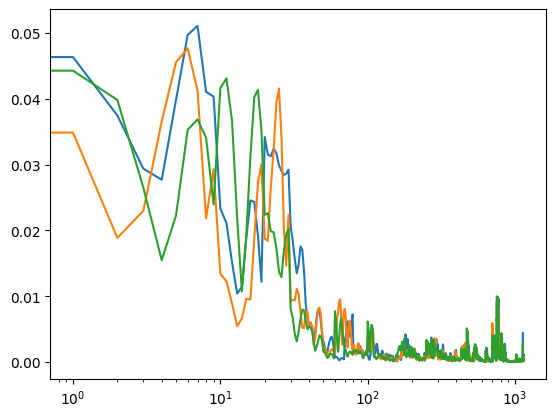

In [31]:
plt.plot(np.array([[l[3] for l in log] for log in logs[0:-1:3]]).reshape(-1))
# plt.plot(np.array([[l[-2] for l in log] for log in logs[0:-1:3]]).reshape(-1))

plt.plot(np.array([[l[3] for l in log] for log in logs[1:-1:3]]).reshape(-1))
# plt.plot(np.array([[l[-2] for l in log] for log in logs[1:-1:3]]).reshape(-1))

plt.plot(np.array([[l[3] for l in log] for log in logs[2:-1:3]]).reshape(-1))
# plt.plot(np.array([[l[-2] for l in log] for log in logs[2:-1:3]]).reshape(-1))

plt.xscale('log')

In [27]:
test_myprob.ldlambda2

0

In [28]:
np.argsort((pops[0].get_f()**2).sum(1))[:30]

array([1485, 1492, 1493, 1487, 1489, 1488, 1490, 1496, 1491, 1503, 1482,
       1497, 1499, 1494, 1484, 1495, 1483, 1486, 1498, 1507, 1506, 1481,
       1512, 1504, 1519, 1500, 1479, 1502, 1505, 1509])

[[<matplotlib.lines.Line2D at 0x7f9141e8bca0>],
 ...]

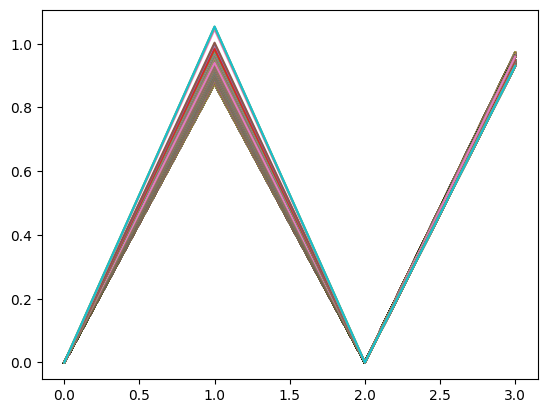

In [332]:
[plt.plot(pops[0].get_f()[x,:]) for x in np.argsort((pops[0].get_f()**2).sum(1))[:]]

In [51]:
np.argmin(((pops[0].get_f()/pops[0].get_f().min(0))).sum(1))

1074

In [62]:
pops[0].get_f()

array([[1.57440928],
       [1.57519618],
       [1.57508909],
       ...,
       [1.57443839],
       [1.57442093],
       [1.57477517]])

In [23]:
np.argmin(pops[1].get_f())

1113

In [89]:
np.argmin((pops[0].get_f()**2).sum(1))

1571

In [19]:
np.argsort((pops[0].get_f()[:,0]))[:50]

array([1485, 1492, 1493, 1487, 1489, 1488, 1490, 1496, 1491, 1503, 1482,
       1497, 1499, 1494, 1484, 1495, 1483, 1486, 1498, 1507, 1506, 1481,
       1512, 1504, 1519, 1500, 1479, 1502, 1505, 1509, 1480, 1511, 1501,
       1510, 1513, 1514, 1515, 1518, 1520, 1508, 1521, 1473, 1478, 1474,
       1476, 1475, 1477, 1472, 1471, 1517])

In [71]:
pops[0].get_f()[153,-1]

0.42561849438587096

In [21]:
pops[0].get_f()[2041]

array([5.82378728])

(array([29.,  0.,  0.,  0.,  0., 40.,  0.,  0.,  0., 31.]),
 array([0.40979661, 0.45385181, 0.49790701, 0.54196221, 0.5860174 ,
        0.6300726 , 0.6741278 , 0.718183  , 0.76223819, 0.80629339,
        0.85034859]),
 <BarContainer object of 10 artists>)

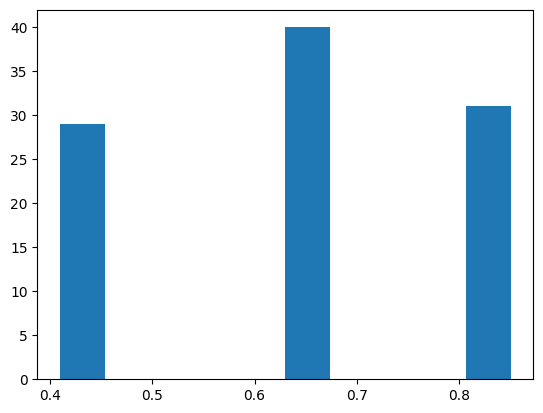

In [188]:
plt.hist(pops[0].get_x()[np.argsort((pops[0].get_f()[:,0]))[:100],-1])

In [20]:
test_myprob._setup_rr()
# train_myprob._setup_rr()

all_test = []
all_results = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
for k,c in enumerate([pops[0].get_x()[1485,:],pops[0].get_x()[1081,:],pops[0].get_x()[2143,:]]):
    if test_myprob.scale: x = test_myprob._unscale(c)
    if test_myprob.log: x = np.array([10**v if k else v for k,v in zip(test_myprob.log,x)])
    test_res = test_myprob._simulate(x)
    # train_res = train_myprob._simulate(10**uc)
    # [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], train_res, train_myprob.metadata, train_myprob.model_stuff)]
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]
    all_test.append(test_res)

    # print(test_myprob.fitness(c))

In [25]:
test_myprob._extra_residual(test_res[0],test_myprob.data[0],test_myprob.data_weights[0],test_myprob.model_stuff[0])

0.42561974267012315

In [21]:
compiled_results = {}
ms = test_myprob.model_stuff[0]
k = 0
prev_i = None
for i, s in zip(test_index_map['index'],test_index_map['sample']):
    if prev_i is not None:
        if i != prev_i:
            k = 0
    compiled_results[s] = all_test[0][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
    k = k+1
    prev_i = i
results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
results_df.columns = ['sample', *ms.species_labels[ms.cols[i]]]

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

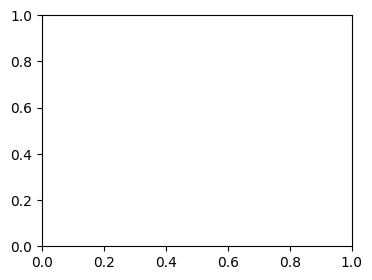

In [22]:
plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00022'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00022'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Pyruvate (mM)')
plt.title('+ Malate')

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00122'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00122'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00122'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00122'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Fumarate (mM)')
plt.title('+ Malate')

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00042'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00042'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00042'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00042'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Succinate (mM)')
plt.title('+ Malate')

plt.figure(figsize=(4,3))
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00048'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00048'].values, 'o--', color='k', alpha = 0.5)
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00048'], 'bo-')
plt.plot([ 10,  40,  70, 130, 250, 490],test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']]['C00048'].values, 'o--', color='k', alpha = 0.5)
plt.ylabel('Glyoxylate (mM)')


In [351]:
metabolites[2]

'C00049'

(0.0, 1.0)

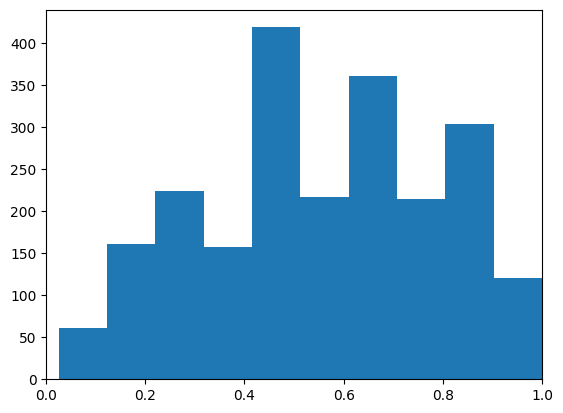

In [52]:
plt.hist(pops[0].get_x()[:,-1])
# plt.hist(pops0[0].get_x()[:,2], alpha = 0.5)
plt.xlim([0,1])

In [46]:
allf = np.array(udbfe._views[0].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly).all_fitness[-4:], ipp.Reference('prob_train')))

In [47]:
allf = allf.reshape(-1,5)

In [408]:
np.argmin(allf.sum(1))

2239

In [410]:
allf[2239]

array([0.        , 0.        , 0.        , 0.55734507, 0.        ])

In [409]:
allf[6]

array([0.        , 0.        , 0.        , 0.55765339, 0.        ])

(0.1, 10)

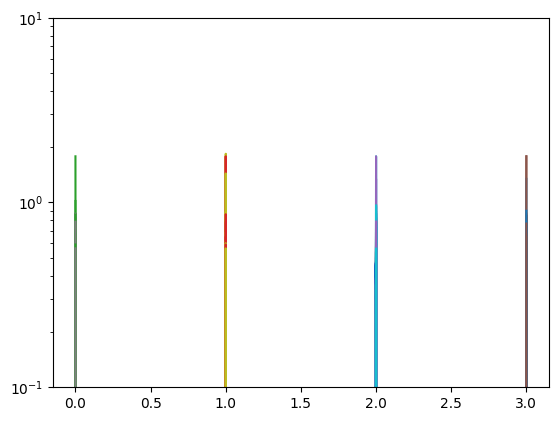

In [49]:
plt.plot(allf.reshape(-1,6).T)
plt.yscale('log')
plt.ylim(0.1,10)

(array([ 282., 1190.,  552.,  183.,   13.,    0.,    0.,    0.,    0.,
          20.]),
 array([0.10332615, 0.19181452, 0.28030289, 0.36879126, 0.45727963,
        0.54576801, 0.63425638, 0.72274475, 0.81123312, 0.8997215 ,
        0.98820987]),
 <BarContainer object of 10 artists>)

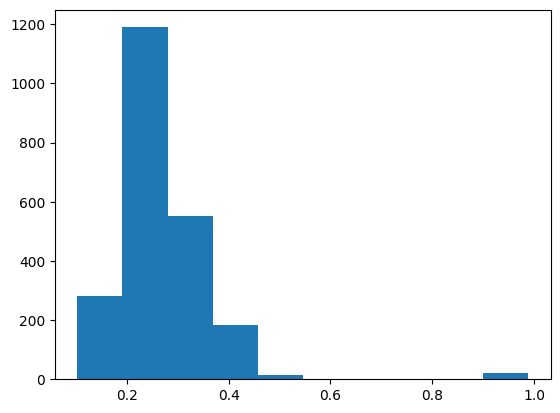

In [214]:
plt.hist(pops[0].get_x()[:,-4])

In [266]:
test_myprob.nominal_fitness

[0.1, 0.01, 0.63, 0.43]

In [50]:
compiled_results = {}
ms = test_myprob.model_stuff[0]
k = 0
prev_i = None
for i, s in zip(test_index_map['index'],test_index_map['sample']):
    if prev_i is not None:
        if i != prev_i:
            k = 0
    compiled_results[s] = test_res[0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
    k = k+1
    prev_i = i
results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
results_df.columns = data_df.columns.values[[0,*np.array(ms.data_cols[5])+1]]

(array([ 5., 12.,  9., 55., 29., 26., 20.,  8.,  2.,  3.]),
 array([-3.36882222, -2.4642408 , -1.55965938, -0.65507796,  0.24950346,
         1.15408488,  2.0586663 ,  2.96324771,  3.86782913,  4.77241055,
         5.67699197]),
 <BarContainer object of 10 artists>)

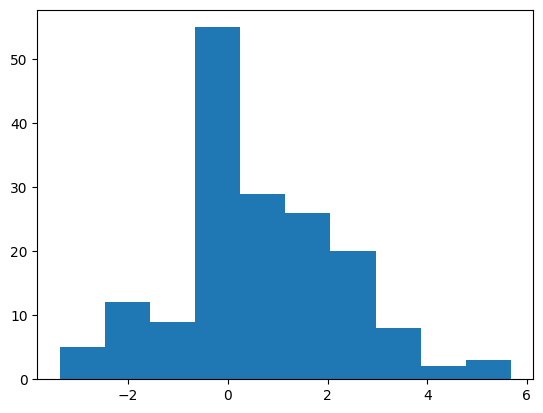

In [51]:
plt.hist(np.log10(((results_df.set_index('sample'))/test_data_df[results_df.columns].set_index('sample')).values.reshape(-1)))

In [413]:
test_weights_df.iloc[:,[0,*np.array(ms.data_cols[5])+1]]

sample    malate  pyruvate    serine   glycine      NADH       coa  \
0       gly_0  0.972679  0.400143  1.988328  0.400143  0.400143  0.400143   
1       mal_0  0.592314  1.607918  0.979710  0.400143  0.998298  0.611353   
2       pyr_0  1.942112  0.862847  0.969451  0.619920  0.631126  0.623071   
3       ser_0  0.973231  0.400143  0.946696  1.988188  0.636701  0.400143   
4     empty_0  0.927869  0.400143  0.947549  0.400143  0.641615  0.400143   
5     NI_0min  0.717040  0.671888  0.689852  0.400143  0.484066  0.992463   
6     PI_0min  0.837253  0.745919  0.782258  0.400143  0.412208  0.540917   
7    ns_20x_1  0.660183  0.636874  0.646147  0.400143  0.670125  0.652135   
8    es_20x_1  0.660183  0.636874  0.646147  0.400143  0.670125  0.652135   
9   E_N_0_20x  0.400143  0.400143  0.400143  0.400143  0.400143  0.652135   
10  N_N_0_20x  0.400143  0.400143  0.400143  0.400143  0.400143  0.400143   
11       R_00  0.660183  0.636874  0.646147  0.400143  0.670125  0.652135   
12       N_00  0.660183  0.636874  0.646147  0.400143  0.670125  0.652135   

    acetylcoa  succinate  fumarate   citrate       atp   alanine  aspartate  
0    0.618811   0.911922  0.966169  0.624655  0.628927  0.889074   0.989318  
1    0.999803   1.926327  1.998035  0.616491  0.619376  0.949541   0.916567  
2    1.000000   0.996366  0.976720  0.633293  0.400143  0.948418   0.860169  
3    0.630014   0.941896  0.957849  0.639250  0.400143  0.819412   0.899458  
4    0.998549   0.760510  0.984039  0.644501  0.652144  0.930921   0.868525  
5    0.971936   0.732453  0.977837  0.556859  0.770502  0.400143   0.719466  
6    0.460756   0.868431  0.950237  0.633883  0.533538  0.895050   0.842161  
7    0.657428   0.668140  0.633046  0.674965  0.687782  0.674933   0.661435  
8    0.657428   0.668140  0.633046  0.674965  0.687782  0.674933   0.661435  
9    0.400143   0.668140  0.400143  0.400143  0.400143  0.400143   0.400143  
10   0.657428   0.668140  0.400143  0.400143  0.400143  0.674933   0.400143  
11   0.657428   0.668140  0.633046  0.674965  0.400143  0.674933   0.661435  
12   0.657428   0.668140  0.633046  0.674965  0.400143  0.674933   0.661435

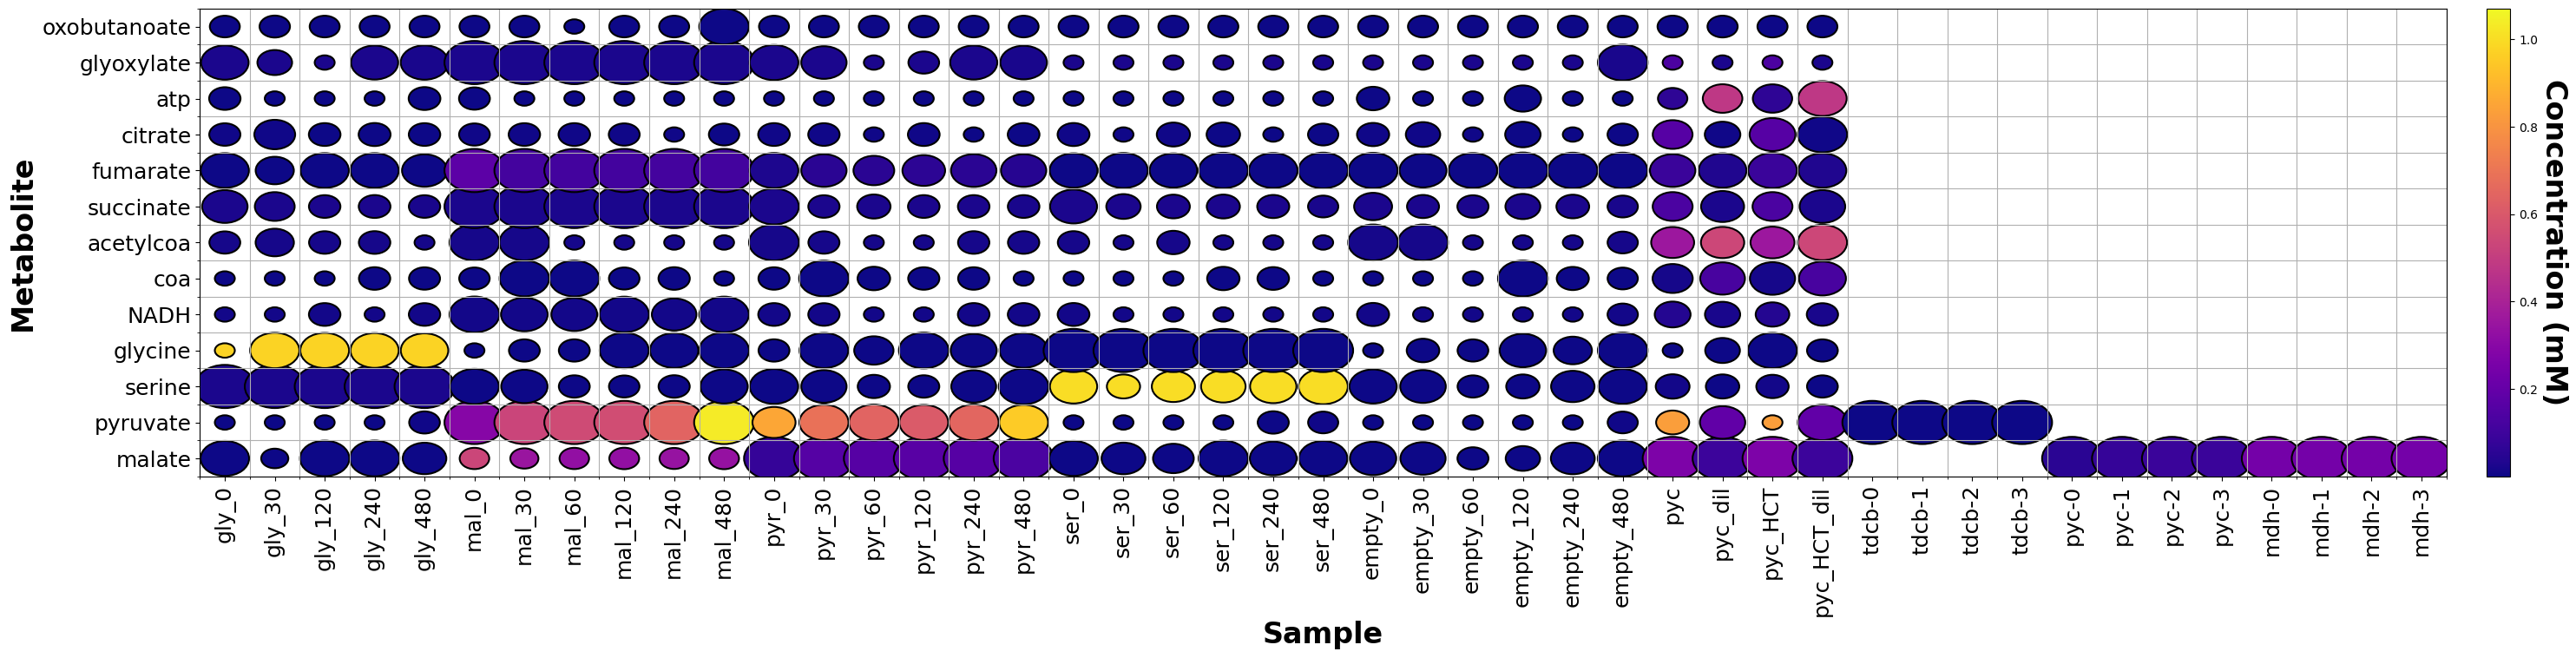

In [97]:
circlemap(results_df, test_weights_df.iloc[:,[0,*np.array(ms.data_cols[5])+1]])

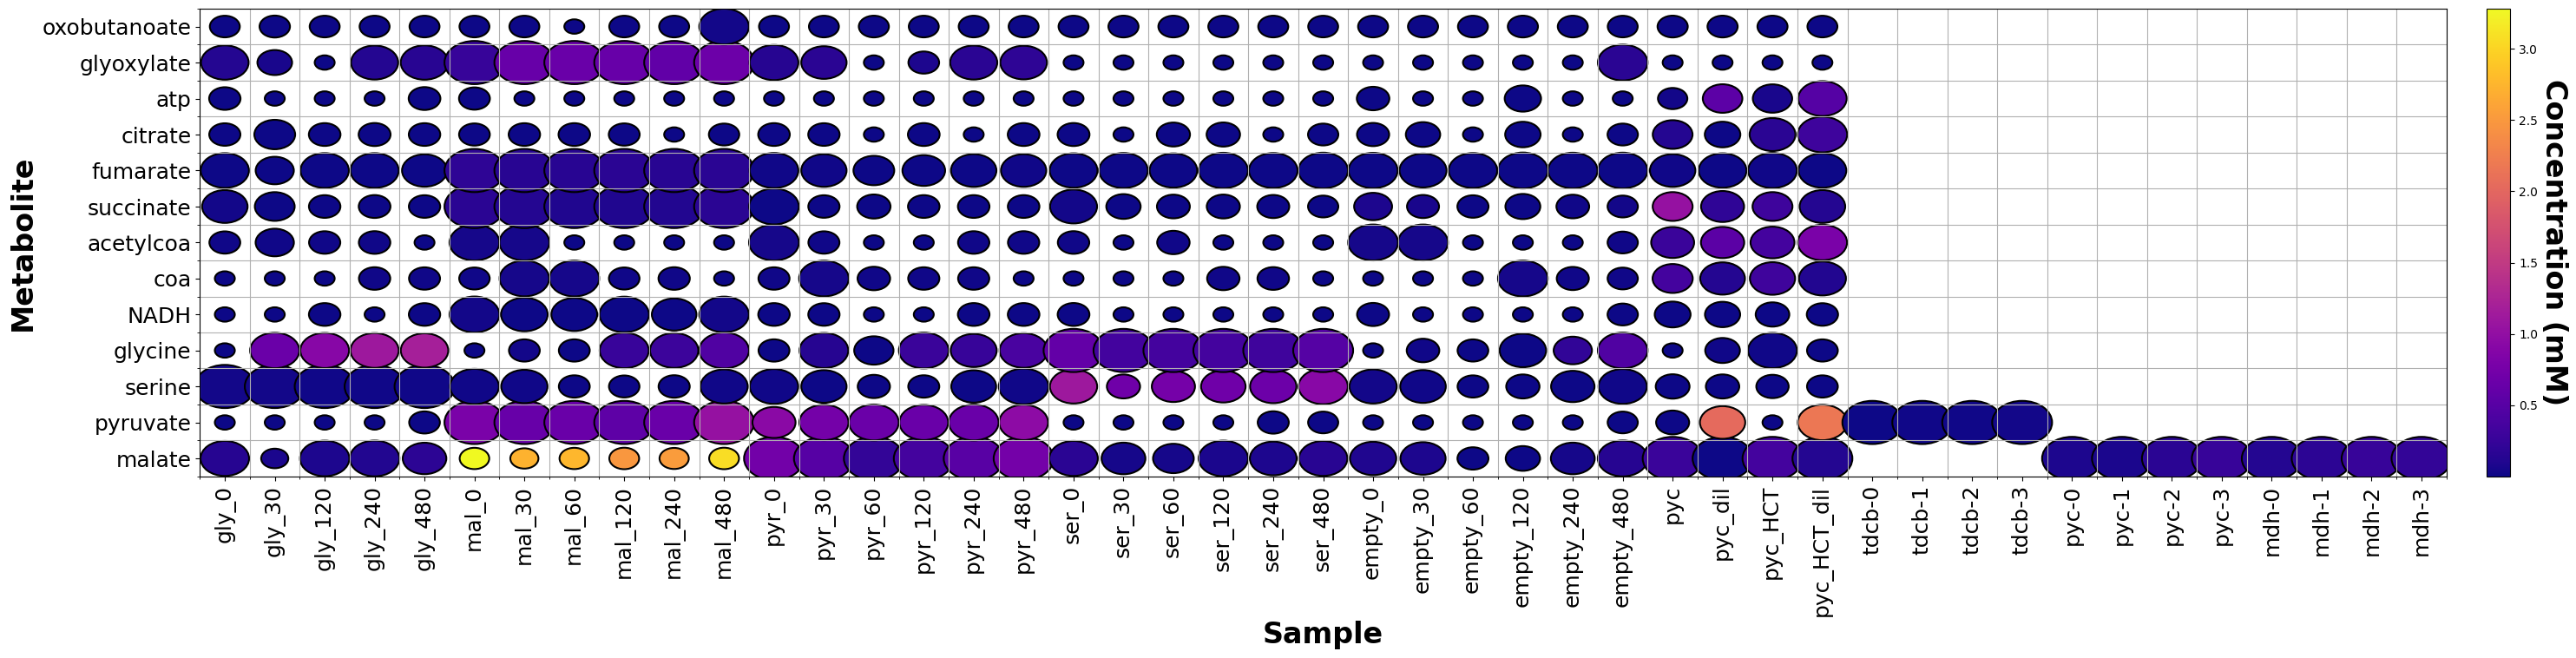

In [96]:
circlemap(test_data_df[results_df.columns], test_weights_df.iloc[:,[0,*np.array(ms.data_cols[5])+1]])

In [56]:
test_myprob.fitness(pops[0].get_x()[453,:]) 

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:610: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:610: RuntimeWarning:

invalid value encountered in divide



[1.905232739333289]

In [60]:
all_res = []
for data,weights,ms,resdict,md in zip(test_myprob.data,test_myprob.data_weights,test_myprob.model_stuff,test_res,test_myprob.metadata):
    er = test_myprob._extra_residual(resdict,data,weights,ms)
    res = []
    for sample, results in resdict.items():
        res.append(test_myprob._residual(results, data[sample], weights[sample], sample, ms, md))
    mean_res = np.nanmean(res,0)
    range_res = np.nanmax(res,0)-np.nanmin(res,0)
    all_res.append(list(mean_res+range_res)+[er])
np.nansum(all_res,0)  

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:610: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:610: RuntimeWarning:

invalid value encountered in divide



array([0.12068755, 0.72008519, 0.18382557, 0.34839224, 0.32377895])

In [63]:
res

[[0.09186526043342523,
  0.7199265086058811,
  0.1445902019814077,
  0.34812476154814054],
 [0.03422068429811157,
  0.7196091510595305,
  0.06611947165547381,
  0.3483030835315087]]

In [61]:
mean_res

array([0.06304297, 0.71976783, 0.10535484, 0.34821392])

In [62]:
range_res

array([0.05764458, 0.00031736, 0.07847073, 0.00017832])

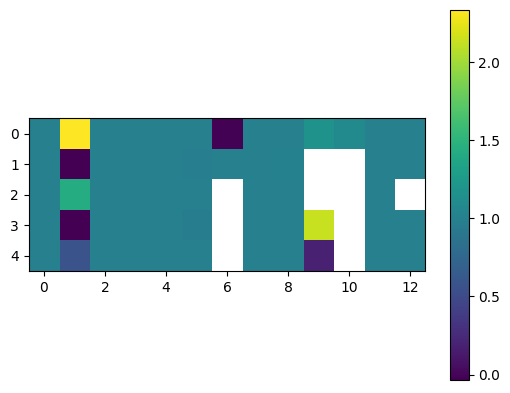

In [64]:
plt.imshow(test_myprob.current_d_erorr[0])
plt.colorbar()

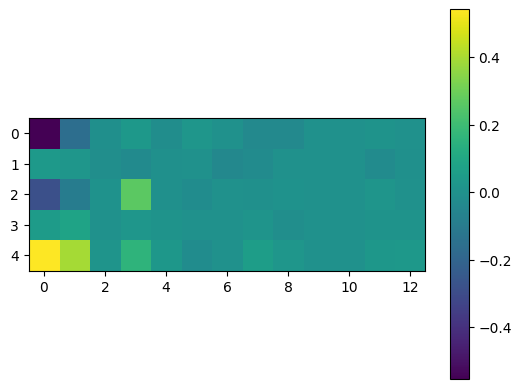

In [66]:
dcols = test_myprob.model_stuff[0].data_cols[5]
rows = test_myprob.model_stuff[0].rows[5]
plt.imshow(np.diff(test_myprob.data[0][5][:,dcols],axis=0))
plt.colorbar()

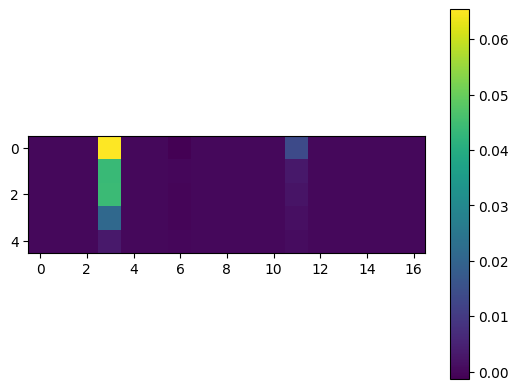

In [270]:
plt.imshow(np.diff(test_res[0][5][rows,:][:,dcols],axis=0))
plt.colorbar()

In [271]:
(d-d*0.01)/(d)

NameError: name 'd' is not defined

In [67]:
dp = np.diff(test_res[0][5][rows,:][:,dcols],axis=0)
d = np.diff(test_myprob.data[0][5][:,dcols],axis=0)
plt.imshow((np.abs((d-d*0.05)/(d)))*((weights[:,dcols]*np.roll(weights[:,dcols],1,axis=0))[:-1,:]), vmax=3)
plt.colorbar()

/tmp/ipykernel_305/510275678.py:3: RuntimeWarning:

invalid value encountered in divide



TypeError: unhashable type: 'slice'

/tmp/ipykernel_187/1407868869.py:1: RuntimeWarning:

divide by zero encountered in divide



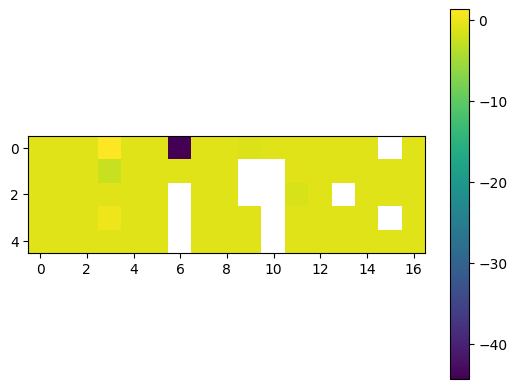

In [273]:
plt.imshow((-np.diff(test_myprob.data[0][5][:,dcols],axis=0)+np.diff(test_res[0][5][rows,:][:,dcols],axis=0))/(np.diff(test_myprob.data[0][5][:,dcols],axis=0)))
plt.colorbar()

In [275]:

dcols = test_myprob.model_stuff[0].data_cols[5]
weights = test_myprob.data_weights[0][5]
# appply error function, then weights
wsq_e = (test_myprob.current_error[0]**2)*weights[:,dcols]
wsq_de = (test_myprob.current_d_erorr[0]**2)*((weights[:,dcols]*np.roll(weights[:,dcols],1,axis=0))[:-1,:])
wsq_le = (test_myprob.current_log_erorr[0]**2)*weights[:,dcols]

wl_e = np.log1p(np.abs(test_myprob.current_error[0]))*weights[:,dcols]
wl_de = np.log1p(np.abs(test_myprob.current_d_erorr[0]))*((weights[:,dcols]*np.roll(weights[:,dcols],1,axis=0))[:-1,:])
wl_le = np.log1p(np.abs(test_myprob.current_log_erorr[0]))*weights[:,dcols]

wrmse_e2 = np.sqrt(np.nansum(wsq_e)/(np.nansum((~np.isnan(wsq_e)))+1e-12))
wrmse_de2 = np.sqrt(np.nansum(wsq_de)/(np.nansum((~np.isnan(wsq_de)))+1e-12))
wrmse_le2 = np.sqrt(np.nansum(wsq_le)/(np.nansum((~np.isnan(wsq_le)))+1e-12))

wll_e2 = np.nansum(wl_e)/(np.nansum((~np.isnan(wl_e)))+1e-12)
wll_de2 = np.ma.masked_invalid(wl_de).mean()/((1-np.ma.masked_invalid(wl_de).mask).sum()+1e-12)
wll_le2 = np.nansum(wl_le)/(np.nansum((~np.isnan(wl_le)))+1e-12)

In [279]:
cols = test_myprob.model_stuff[0].cols[5]
rows = test_myprob.model_stuff[0].rows[5]
all_r = udbfe._views[0].apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly).current_results[0][5][rows,:][:,cols], ipp.Reference('prob_train'))

(array([1., 1., 0., 0., 1., 0., 0., 1., 0., 1.]),
 array([0.32557442, 0.46912038, 0.61266634, 0.75621231, 0.89975827,
        1.04330423, 1.1868502 , 1.33039616, 1.47394212, 1.61748809,
        1.76103405]),
 <BarContainer object of 10 artists>)

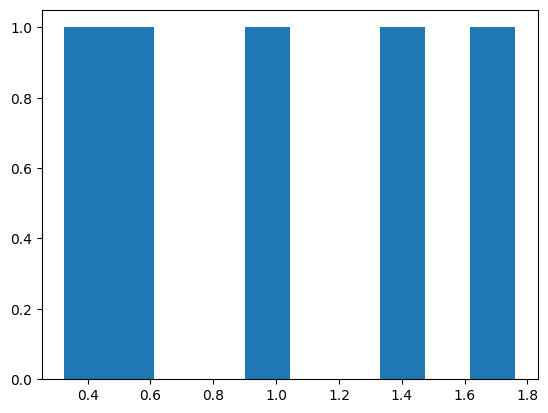

In [298]:

plt.hist(np.abs(np.diff(test_myprob.data[0][5],axis=0)).sum((1)))

(array([ 23.,  47.,  52., 259., 168.,   7.,   2.,   1.,   0.,   1.]),
 array([0.        , 0.02533662, 0.05067324, 0.07600987, 0.10134649,
        0.12668311, 0.15201973, 0.17735635, 0.20269297, 0.2280296 ,
        0.25336622]),
 <BarContainer object of 10 artists>)

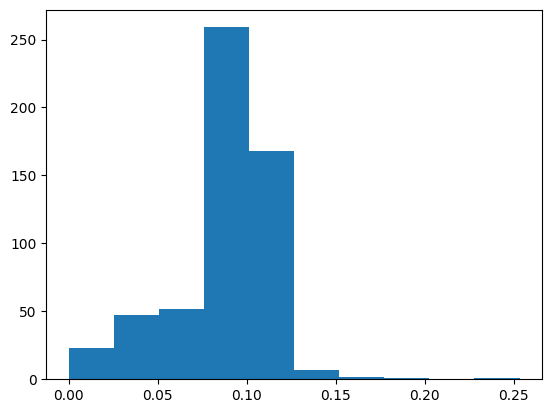

In [293]:
plt.hist(np.abs(np.diff(all_r,axis=1)).sum((1,2)))

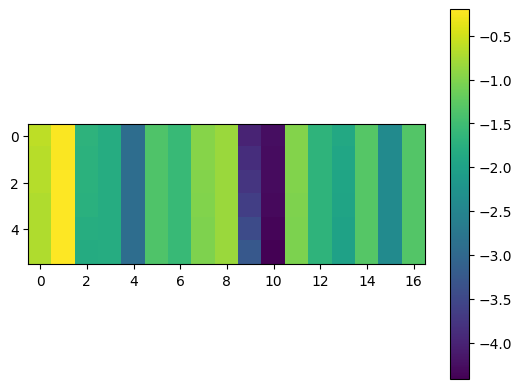

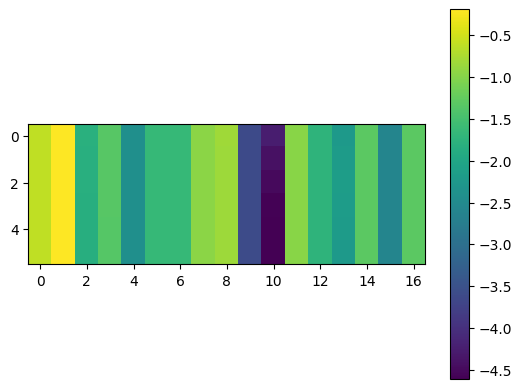

In [280]:
plt.imshow(np.log10(np.array(all_r)[0,:,:]))
plt.colorbar()

plt.figure()
plt.imshow(np.log10(np.array(all_r)[-8,:,:]))
plt.colorbar()

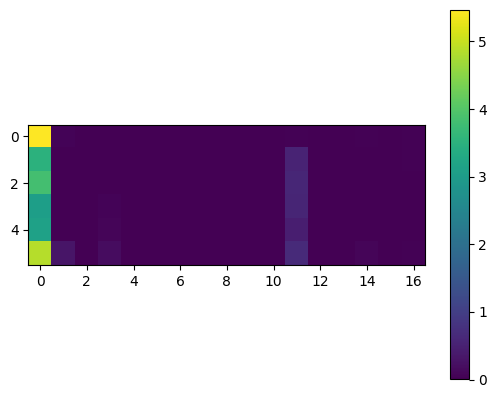

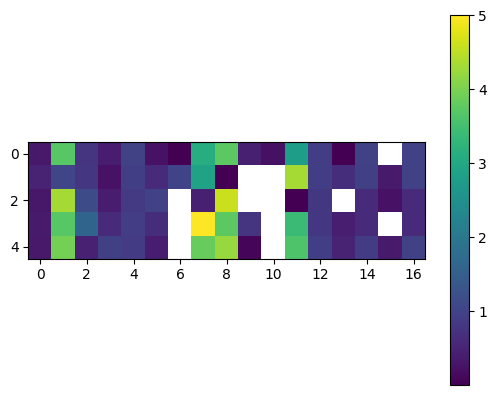

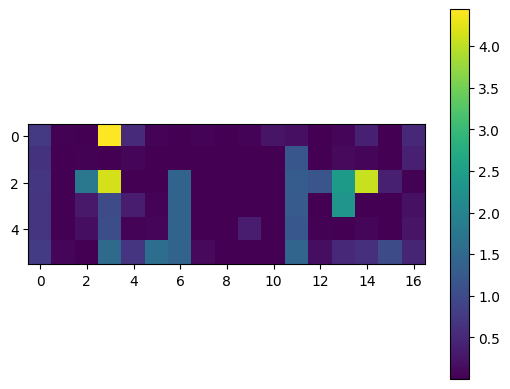

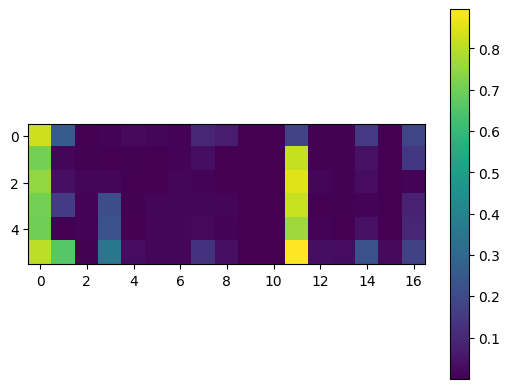

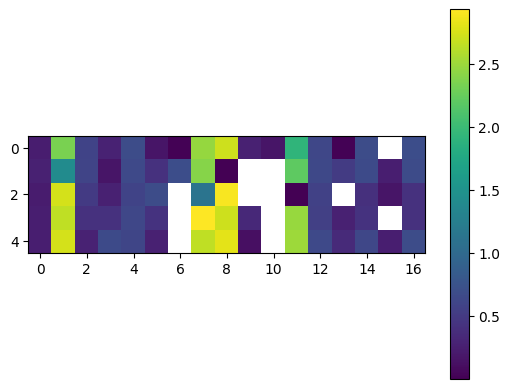

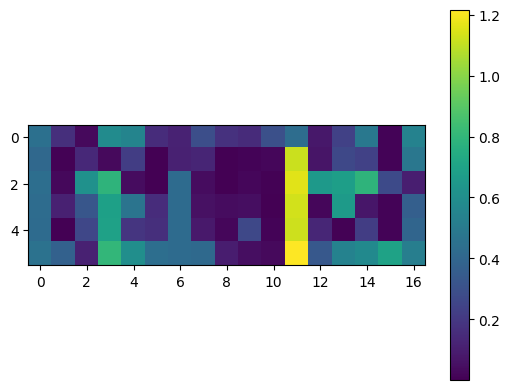

In [276]:
plt.imshow(wsq_e)
plt.colorbar()

plt.figure()
plt.imshow(wsq_de)
plt.colorbar()

plt.figure()
plt.imshow(wsq_le)
plt.colorbar()

plt.figure()
plt.imshow(wl_e)
plt.colorbar()

plt.figure()
plt.imshow(wl_de)
plt.colorbar()

plt.figure()
plt.imshow(wl_le)
plt.colorbar()

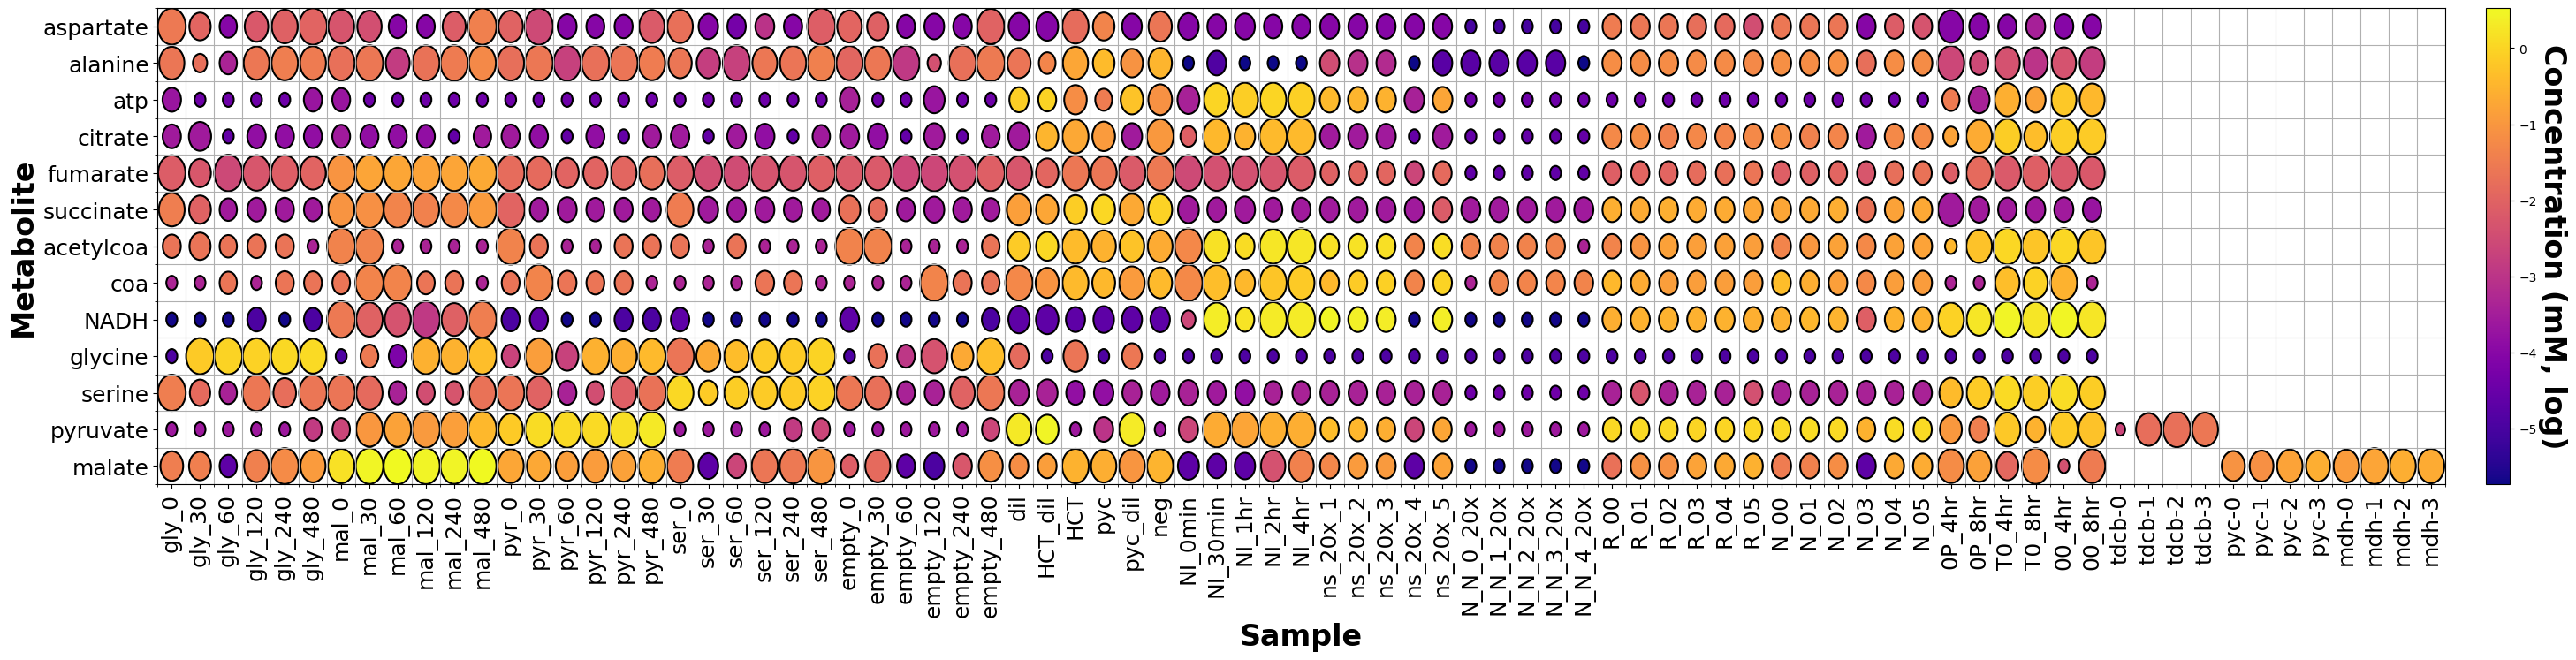

In [ ]:
circlemap(train_data_df.iloc[:,[0,*np.array(ms.data_cols[0])+1]], train_weights_df.iloc[:,[0,*np.array(ms.data_cols[0])+1]])

In [98]:
len(rdf.drop(columns=['sample'], inplace=False).values.flatten())

585

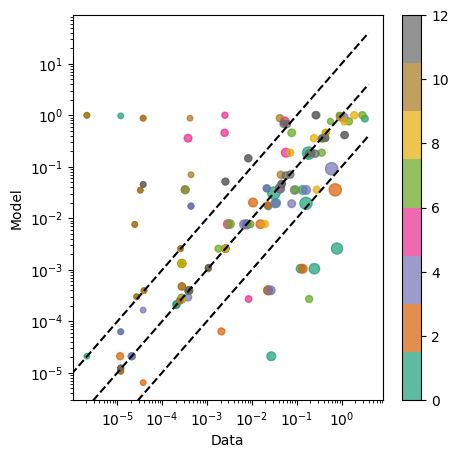

In [23]:
for rdf in [results_df]:#, results_df1, results_df2]:
    plt.figure(figsize=(5,5))
    plt.scatter(test_data_df[rdf.columns].drop(columns=['sample'], inplace=False).values.flatten(), 
                rdf.drop(columns=['sample'], inplace=False).values.flatten(), 
                s = ((test_weights_df.drop(columns=['sample'], inplace=False).iloc[:,test_myprob.model_stuff[0].data_cols[5]].values.flatten()))*40, 
                alpha=0.7, 
                c = (test_index_map['index'].values[np.newaxis].T*np.ones((len(rdf),len(rdf.columns)-1))).flatten(), cmap = 'Dark2')

    plt.xlabel('Data')
    plt.ylabel('Model')
    plt.plot([0,4],[0,4],'k--')
    plt.plot([0,4],[0,40],'k--')
    plt.plot([0,4],[0,0.40],'k--')
    plt.yscale('log')
    plt.xscale('log')
    plt.colorbar()

In [34]:
mean3 = np.mean(np.log10([(results_df0.set_index('sample')).values,(results_df1.set_index('sample')).values, (results_df2.set_index('sample')).values]),0)
std3 = np.std(np.log10([(results_df0.set_index('sample')).values,(results_df1.set_index('sample')).values, (results_df2.set_index('sample')).values]),0)

/opt/conda/envs/myenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log10



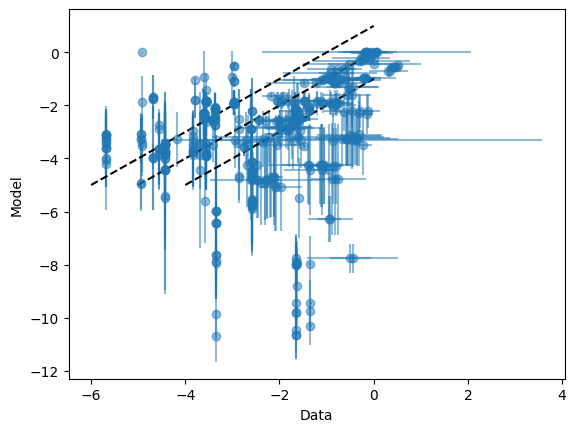

In [35]:
plt.errorbar(np.log10(test_data_df[results_df.columns].drop(columns=['sample'], inplace=False).values.flatten()), mean3.flatten(), yerr = std3.flatten(),
xerr =5*np.std([np.log10(test_data_df[results_df.columns].set_index('sample')+test_stds_df[results_df.columns].set_index('sample')),np.log10(test_data_df[results_df.columns].set_index('sample')-test_stds_df[results_df.columns].set_index('sample')),np.log10(test_data_df[results_df.columns].set_index('sample'))],0).flatten()
, fmt = 'o', alpha = 0.5)
plt.xlabel('Data')
plt.ylabel('Model')
plt.plot([-5,0],[-5,0],'k--')
plt.plot([-4,0],[-5,-1],'k--')
plt.plot([-6,0],[-5,1],'k--')
# plt.yscale('log')
# plt.xscale('log')

In [38]:
best = np.concatenate([np.apply_along_axis(lambda x: (x),1, p.get_x()[np.argsort(p.get_f()[:,0])[:100],:]) for p in pops])

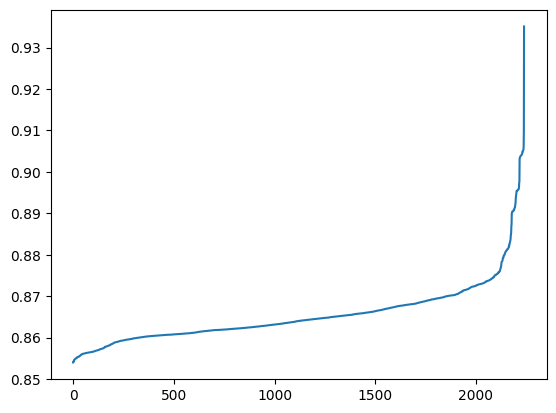

In [39]:
plt.plot(np.sort(pops[0].get_f()[:,0]))

In [40]:
plt.plot(std3.mean(0))

NameError: name 'std3' is not defined

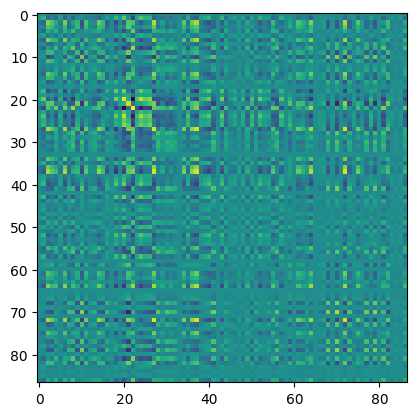

In [134]:
plt.imshow(np.cov([pops[0].get_x()[619,:],pops[1].get_x()[2121,:],pops[2].get_x()[1513,:]],rowvar=False))

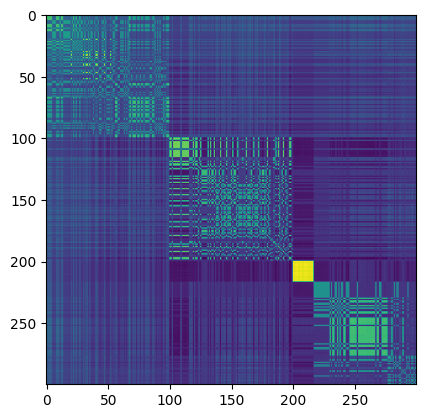

In [41]:
plt.imshow(best@best.T)

(array([ 5., 12., 10., 16., 16., 18., 14.,  7.,  1.,  1.]),
 array([1.9171572 , 2.13900049, 2.36084378, 2.58268708, 2.80453037,
        3.02637366, 3.24821696, 3.47006025, 3.69190355, 3.91374684,
        4.13559013]),
 <BarContainer object of 10 artists>)

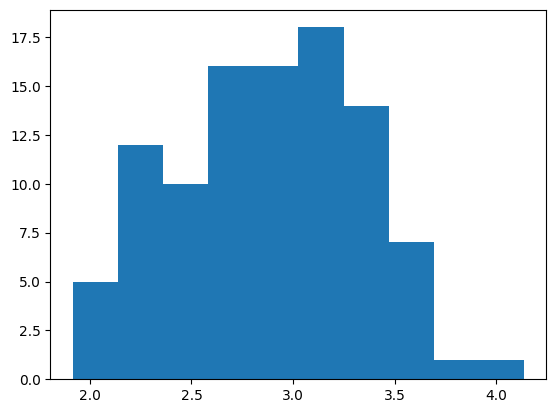

In [43]:
plt.hist([test_myprob._unscale(np.random.multivariate_normal(np.mean(best,0),np.cov(best,rowvar=False)))[-1] for i in range(100)])

<ErrorbarContainer object of 3 artists>

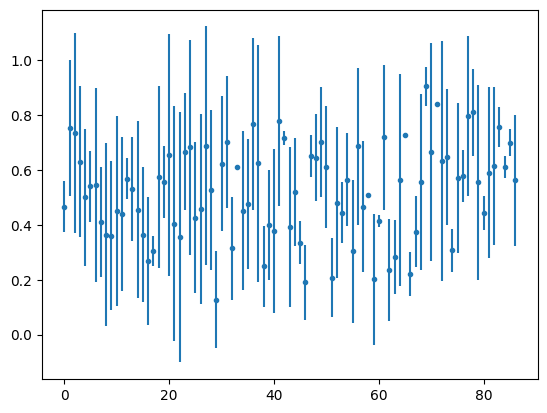

In [86]:
plt.errorbar(range(len(parameter_labels)),np.mean([pops[0].get_x()[619,:],pops[1].get_x()[2121,:],pops[2].get_x()[1513,:]],0),yerr=np.std([pops[0].get_x()[619,:],pops[1].get_x()[2121,:],pops[2].get_x()[1513,:]],0),fmt='.')

(array([ 3., 10.,  8., 50., 43., 15., 26., 10.,  1.,  3.]),
 array([-3.49276764, -2.57478161, -1.65679559, -0.73880956,  0.17917647,
         1.09716249,  2.01514852,  2.93313455,  3.85112057,  4.7691066 ,
         5.68709262]),
 <BarContainer object of 10 artists>)

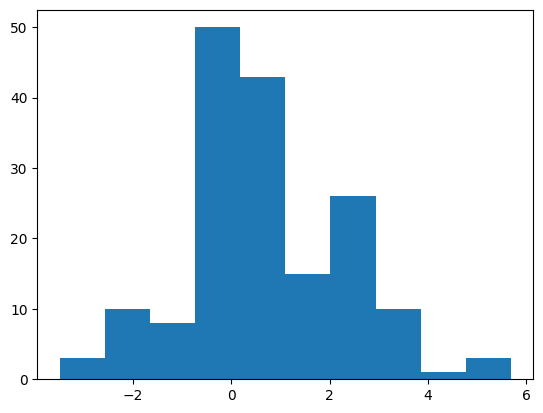

In [51]:
plt.hist(np.log10(((results_df2.set_index('sample'))/test_data_df[results_df.columns].set_index('sample')).values.reshape(-1)))

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(train_data_df.drop(columns=['sample','C00047'], inplace=False).iloc[:,np.array(ms.data_cols[0])].values.flatten(), 
            results_df.drop(columns=['sample'], inplace=False).values.flatten(), 
            s = np.exp(np.exp(train_weights_df.drop(columns=['sample','lysine'], inplace=False).iloc[:,np.array(ms.data_cols[0])].values.flatten()))*4, 
            alpha=0.7, 
            c = (train_index_map['index'].values[np.newaxis].T*np.ones((len(train_data_df),len(results_df.columns)-1))).flatten(), cmap = 'Dark2')

plt.plot([0,4],[0,4],'k--')
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

KeyError: 0

<Figure size 1000x1000 with 0 Axes>

ValueError: x and y must be the same size

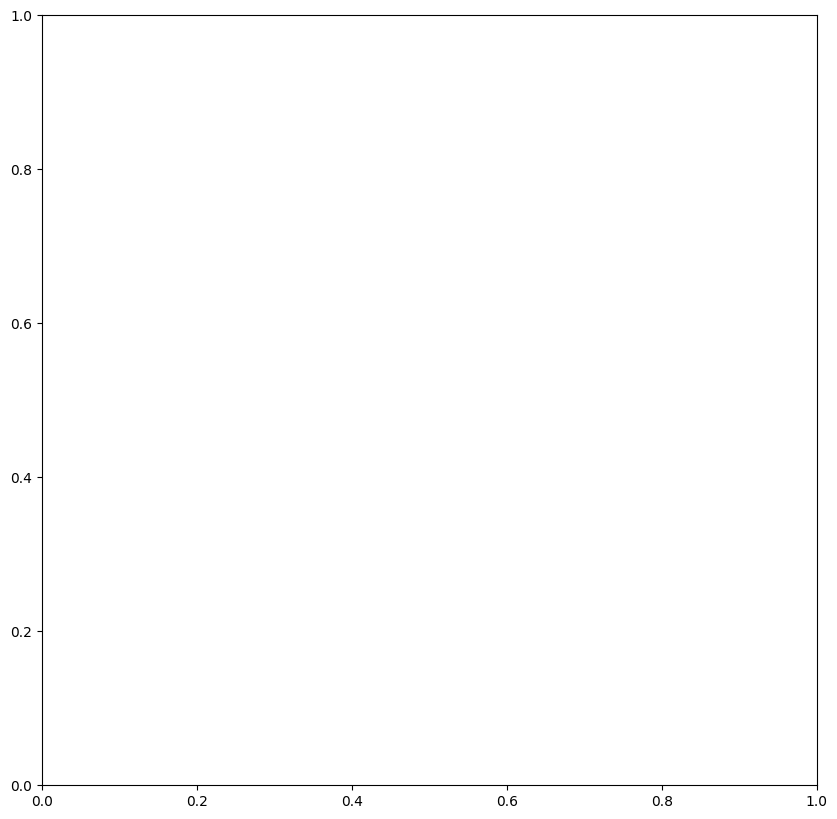

In [105]:
plt.figure(figsize=(10,10))
plt.scatter(train_data_df.drop(columns=['sample','C00047'], inplace=False).iloc[:,np.array(ms.data_cols[5])].values.flatten(), 
            results_df.drop(columns=['sample'], inplace=False).values.flatten(), 
            s = np.exp(np.exp(train_weights_df.drop(columns=['sample','lysine'], inplace=False).iloc[:,np.array(ms.data_cols[5])].values.flatten()))*4, 
            alpha=0.7, 
            c = (np.arange(len(results_df.columns)-1)[np.newaxis]*np.ones((len(train_data_df),len(results_df.columns)-1))).flatten(), cmap = 'Dark2')

plt.plot([0,4],[0,4],'k--')
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

In [ ]:
ersu

In [30]:
abs_error = np.abs(test_data_df.drop(columns=['sample'], inplace=False).iloc[:,np.array(ms.data_cols[5])].values-results_df0.drop(columns=['sample'], inplace=False).values)*test_weights_df.drop(columns=['sample'], inplace=False).iloc[:,np.array(ms.data_cols[5])].values
met_err = np.nanmean(abs_error,axis=0)
exp_err = np.nanmean(abs_error,axis=1)

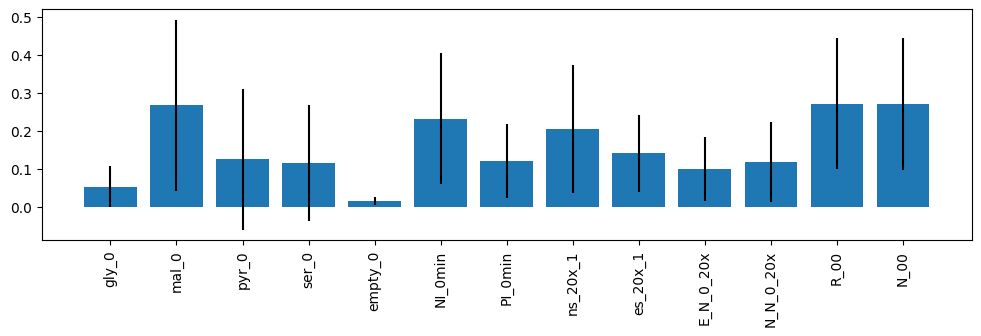

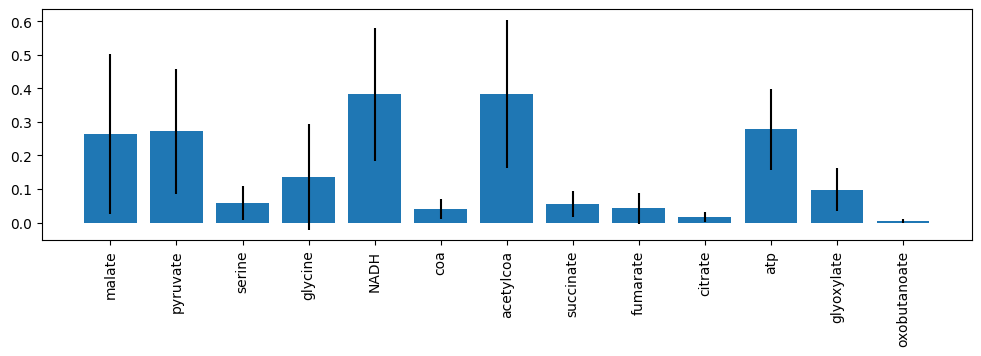

In [31]:
plt.figure(figsize=(12,3))
plt.bar(range(len(exp_err)),exp_err, yerr=np.nanstd(abs_error,axis=1)/2)
plt.xticks(range(len(exp_err)),test_data_df['sample'], rotation=90)

plt.figure(figsize=(12,3))
plt.bar(range(len(met_err)),met_err, yerr=np.nanstd(abs_error,axis=0)/2)
plt.xticks(range(len(met_err)),train_weights_df.drop(columns=['sample'], inplace=False).iloc[:,np.array(ms.data_cols[5])].columns, rotation=90);


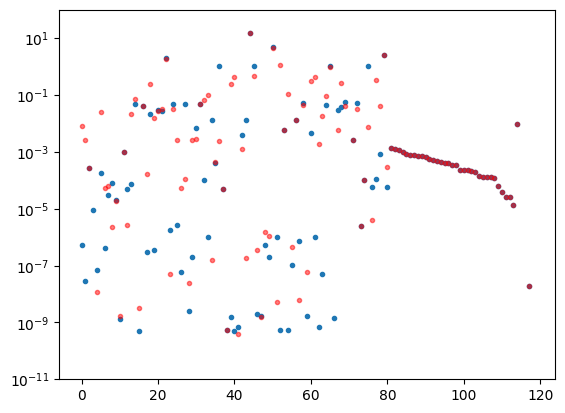

In [202]:
plt.plot(test_res[0][5][0,:],'.')
plt.plot(test_res[0][5][-1,:],'.r', alpha =0.5)
plt.ylim(1/100000000000,100)
plt.yscale('log')

In [ ]:
top = pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:5],:]
mean = np.array(top.mean(axis=0))
std = np.array(top.std(axis=0))

std[(mean<0.8)*(mean>0.1)] = np.nan
plot_labels = np.array(parameter_labels)
plot_labels[(mean<0.8)*(mean>0.1)] = ''
inital = test_myprob._scale(p_initial)
inital[(mean<0.8)*(mean>0.1)] = np.nan
mean[(mean<0.8)*(mean>0.1)] = np.nan


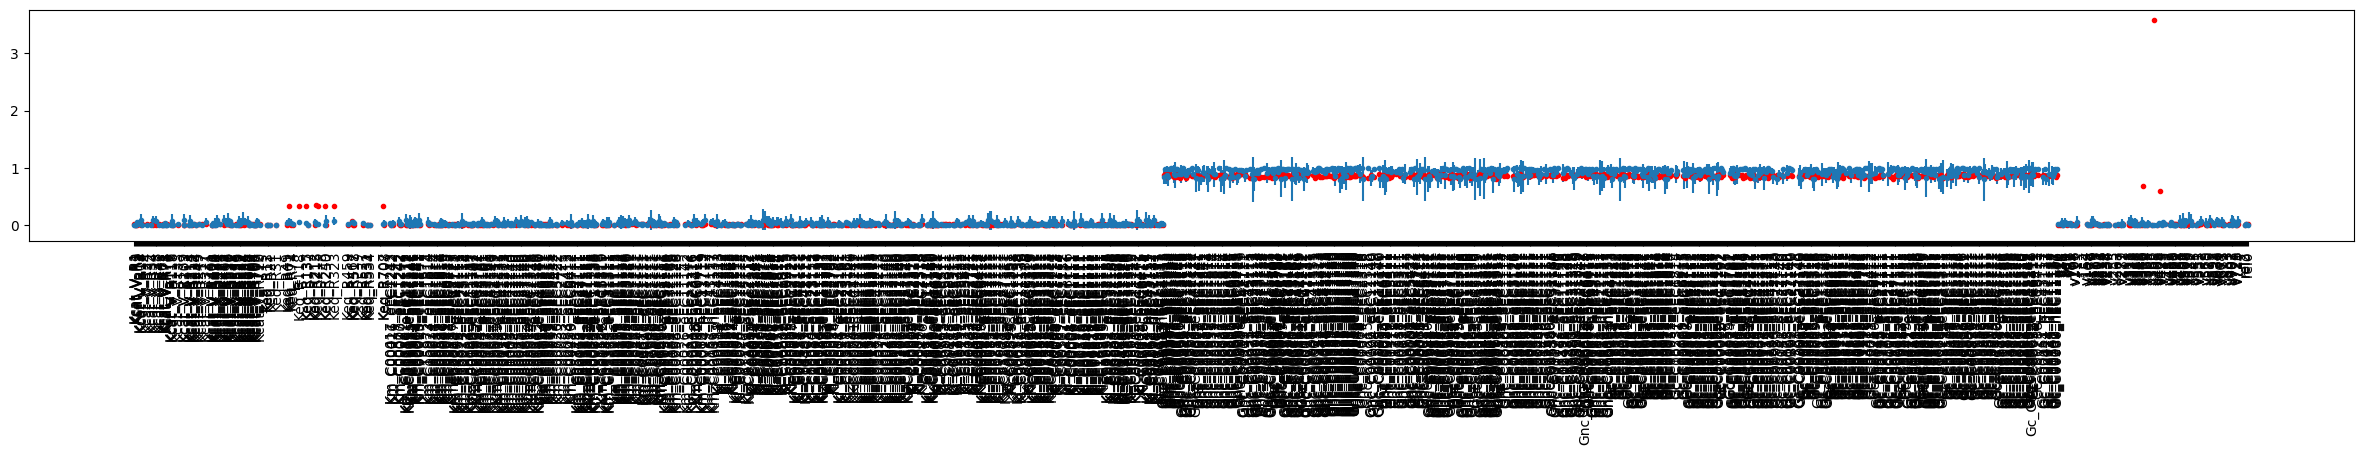

In [ ]:
plt.figure(figsize=(30,3))
plt.errorbar(range(len(top[0,:])),mean,yerr=std, fmt='.')
plt.plot(range(len(top[0,:])),inital,'r.')
plt.xticks(range(len(plot_labels)),plot_labels, rotation = 90);

In [55]:
x = pops[0].get_x()[1400]

if test_myprob.scale: x = test_myprob._unscale(x)
if test_myprob.log: x = np.array([10**v if k else v for k,v in zip(test_myprob.log,x)])

for r,ms, metadata, variables in zip(test_myprob.r, test_myprob.model_stuff, test_myprob.metadata, test_myprob.variables):
    results = {sample:np.ones((test_myprob.cvode_timepoints,len(ms.species_labels)))*1e12 for sample in metadata['sample_labels']}
    for sample in metadata['sample_labels'][:1]:
        
        x_dict = {k:v for k,v in zip(test_myprob.parameter_labels,x)}
        for label, value in variables[sample].items():
            if not np.isnan(value):
                if label in ms.species_labels:
                    x_dict[ms.species_to_v[label]]=(value+x_dict[ms.species_to_v[label]]*ms.species_init[label]*variables[sample]['dilution_factor'])/(ms.species_init[label]*variables[sample]['dilution_factor'])

        x2 = np.array(list(x_dict.values()))
        r.model.setGlobalParameterValues([*ms.parameter_order, *ms.variable_order[sample]], [*x2[ms.parameter_present], *np.array(list(variables[sample].values()))[ms.variable_present[sample]]])
        r.reset()

        try:
            results[sample] = r.simulate(0,metadata['timepoints'][sample][-1],test_myprob.cvode_timepoints)[:,1:].__array__()
        except Exception as e:
            print(e)
            # break # stop if any fail
        # r.resetToOrigin()

In [144]:
r.getReactionRates()[53]

8.179556962441407e-121

In [56]:
np.where([i == 'R371' for i in r.model.getReactionIds()])

(array([124]),)

In [145]:
r['init(eEC27140)']

6.558435178235698e-06

In [146]:
r['eEC27140']/r['init(eEC27140)']

0.9844680034380031

In [168]:
r['eEC27140_Dreg']

6386.790022150104

In [148]:
r['init(eEC1351)']

2.522478787055787e-07

In [149]:
r['kdeg_eEC1351']

0.0008810498426564513

In [151]:
r['D_eEC2792']

0.0

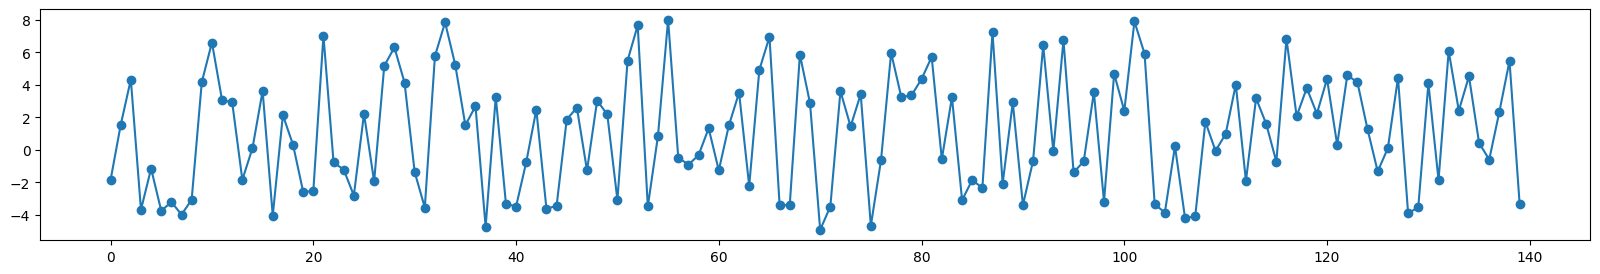

In [85]:
plt.figure(figsize=(20,3))
plt.plot(np.log10([r[k] for k in kcat_labels]),'o-')

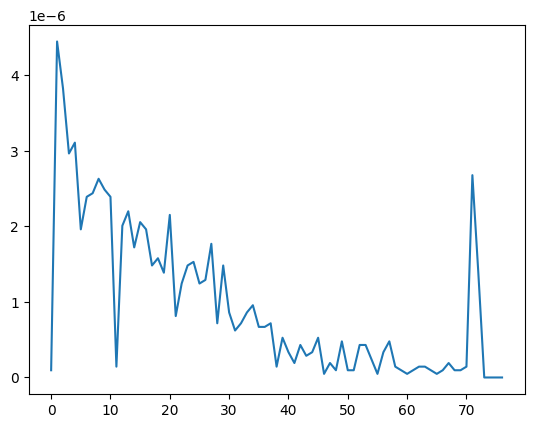

In [58]:
# plt.plot(np.log10([r[e] for e in [s for s in r.getFloatingSpeciesIds() if 'EC' in s]]))
plt.plot(([r['init('+e+')'] for e in [s for s in r.getFloatingSpeciesIds() if 'EC' in s]]))

<Axes: >

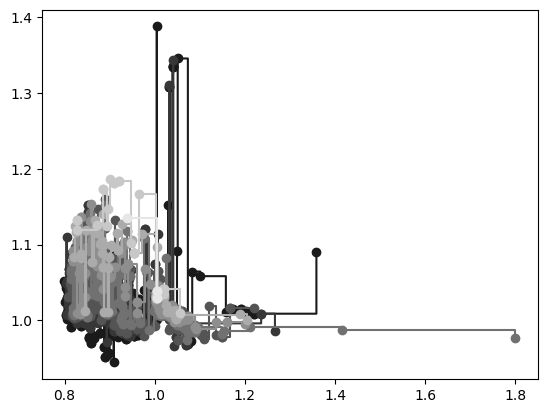

In [134]:
pg.plot_non_dominated_fronts(pops[0].get_f(), comp = [0,1])

<Axes: >

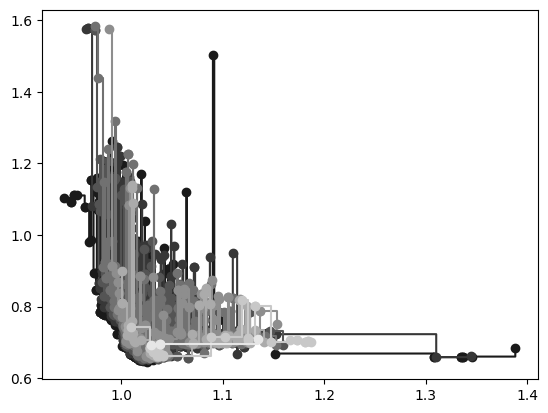

In [135]:
pg.plot_non_dominated_fronts(pops[0].get_f(), comp = [1,2])

<Axes: >

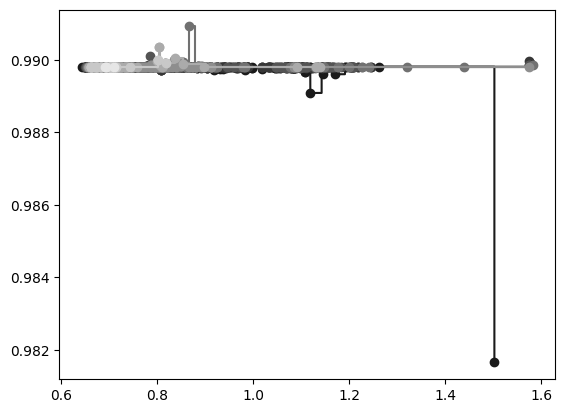

In [136]:
pg.plot_non_dominated_fronts(pops[0].get_f(), comp = [2,3])

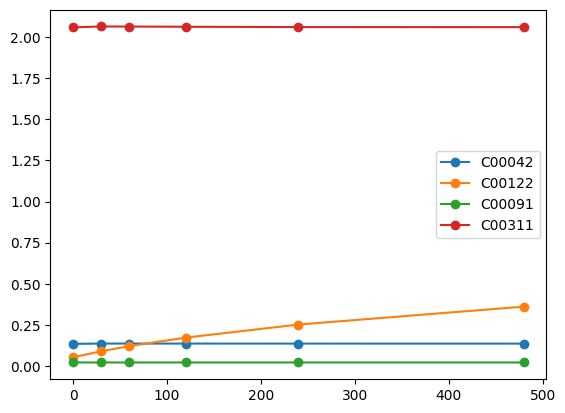

In [192]:
[plt.plot([0,30,60,120,240,480],all_test[0][0][5][:,np.where([l == s for s in r.getFloatingSpeciesIds()])[0][0]][ms.rows[5]], 'o-',label = l) for l in  ['C00042','C00122','C00091','C00311']]
plt.legend()


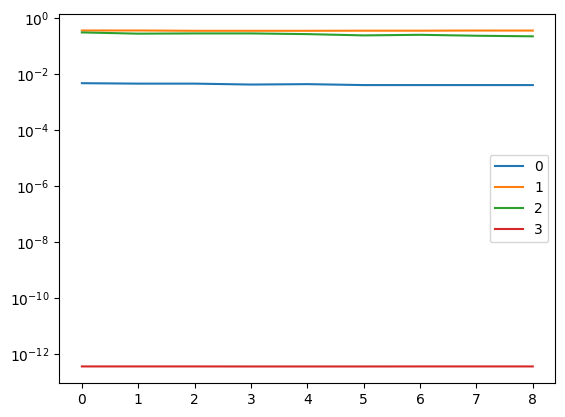

In [45]:
plt.plot(np.array([f[0].min(0) for f in all_fs]))
plt.yscale('log')
plt.legend(range(4))

Text(0.5, 0, 'iteration')

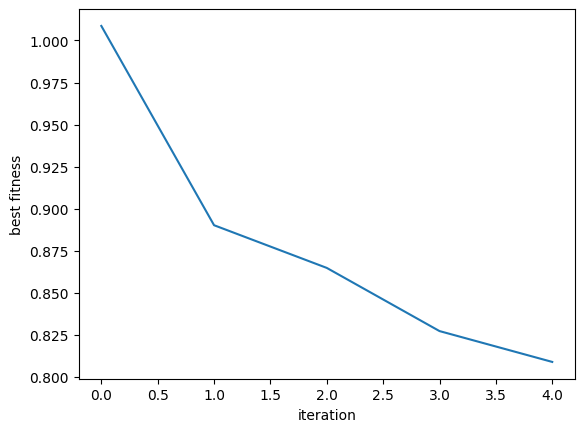

In [137]:
plt.plot([np.min((f[0]**2).mean(1)) for f in all_fs])
plt.ylabel('best fitness')
plt.xlabel('iteration')

(array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.]),
 array([0.86435155, 0.86639143, 0.8684313 , 0.87047118, 0.87251105,
        0.87455093, 0.8765908 , 0.87863068, 0.88067055, 0.88271043,
        0.8847503 ]),
 <BarContainer object of 10 artists>)

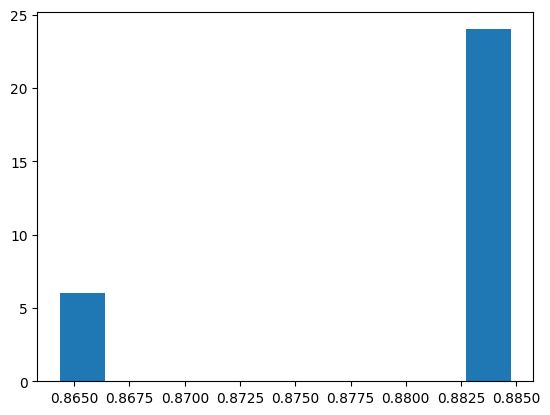

In [59]:
N = 30
plt.hist(pops[0].get_x()[np.argsort((pops[0].get_f()[:,0]))[:30],-1])

[<ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 ar

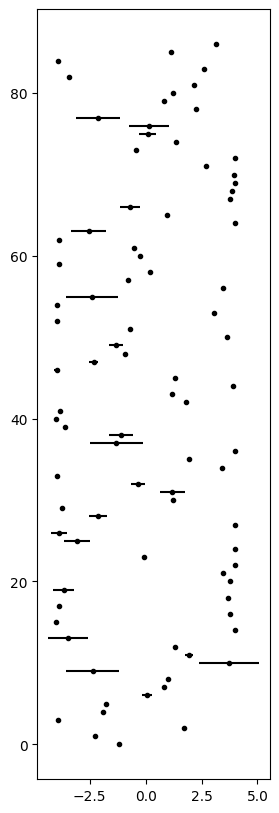

In [184]:
N = 30
ux = np.apply_along_axis(lambda x: test_myprob._unscale(x), 1, pops[0].get_x())
top = [ux[np.argsort((pops[0].get_f()[:,0]))[:N],k] for k in range(len(parameter_labels))]
plt.figure(figsize=(3,10))
[plt.errorbar(top[k].mean(0), k, xerr=top[k].std(0), fmt='k.', label = parameter_labels[k]) for k in range(len(parameter_labels))]